# Automating Analog Layouts: A Proof of Concept with GLayout for Streamlined Design Process
---



```
OpenFASOC Team, September 2024
SPDX-License-Identifier: Apache-2.0
```

|Name|Affiliation|IEEE Member|SSCS Member|Email|
|:--:|:----------:|:----------:|:----------:|:----------:|
|Eva Deltor|Institute of Microelectronics of Barcelona (IMB-CNM-CSIC) - UAB|No|No|evamaria.deltor@gmail.com|


Disclaimer! The following project has been developed on Google Colab, therefore in order to run the files .sch and .spice must be moved where the notebook is being run. In case of Google Colab they must be uploaded. Also it seems that the images can be seen properly, in case that is not the situation please open it in the following link:

https://colab.research.google.com/drive/1Wjdyihl7EdNZLGDe15rMFXoDqOg_lkGE?usp=sharing

In [30]:
![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repository/blob/branch/path/to/notebook.ipynb)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repository/blob/branch/path/to/notebook.ipynb)'


## Introduction
GLayout is a technology-independent analog layout generator that allows users to seamlessly transition a design from one process design kit (PDK) technology to another without the need to redo the entire layout. It simplifies the layout creation process, as parameters like width and length can be easily modified, and the design updates automatically.

However, the designer must perform an initial iteration, which includes defining the floorplan, setting limits, checking rules, and making connections, among other tasks. The purpose of this notebook is to reduce that workload. The goal is that once the designer has completed the schematic tests, they can import the .sch and .spice files into this code and receive the .gds file in return, regardless of the type of circuit, the number of transistors or connections.

However, since this is just an initial proof of concept, I've acknowledged a few limitations. The biggest one is related to area optimization. From the designs shown during the SSCS'25 course, it's clear that the area wasn't optimized (example below), so I've kept it simple for now. Optimizing the area would require a more complex algorithm, which should be tackled in future updates.

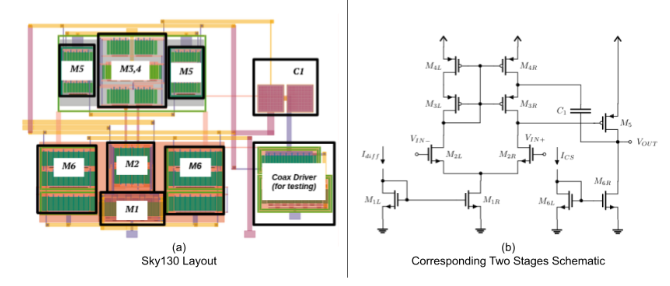

The procedure for transitioning from schematic design to layout involves two main steps:

1. Extract positions from the .sch file: The schematic's positions are extracted, and the transistors are placed in a similar manner to the schematic design. This method was chosen because, in my experience, the layout often mirrors the schematic structure. These positions are then sent to the algorithm to place the transistors in the floorplan. One advantage of this approach is that if the designer wants to position the layout in a specific way, they only need to define it in the schematic design. This file has this structure:
```
	C {ipin.sym} 840 210 0 1 {name=p1 lab=VIN+}
	C {ipin.sym} 540 210 0 0 {name=p2 lab=VIN-}
	C {opin.sym} 970 200 0 0 {name=p3 lab=VOUT}
	C {pmos3.sym} 950 -30 0 0 {name=X2 model=irf5305}
	C {pmos3.sym} 950 70 0 0 {name=X4 model=irf5305}
	C {pmos3.sym} 390 -30 0 1 {name=X6 model=irf5305 w=1u l = 1u}
	C {pmos3.sym} 390 70 0 1 {name=X8 model=irf5305}
	C {pmos3.sym} 820 210 0 1 {name=X9 model=irf5305}
```
2. Extract connectivity from the .spice file: The .spice file helps determine the connections for each transistor pin. A graph has been created to retrieve this information due to its ease of accessing connections and interpreting results. Initially, the plan was to hard code multiple functions to achieve this, but the graph representation proved to be much more powerful. The algorithm uses the graph to retrieve wire connections between transistors. This file has this structure:   
```
    X2 net13 net12 VDD irf5305
    X4 VOUT net11 net13 irf5305
    X6 net12 net12 VDD irf5305
    X8 net11 net11 net12 irf5305
    X9 net8 VIN+ IBIAS irf5305
    X10 net9 VIN- IBIAS irf5305
    X11 VOUT net8 net7 irf540 m=1
```



All in all, the pipeline can be summarized as follows:
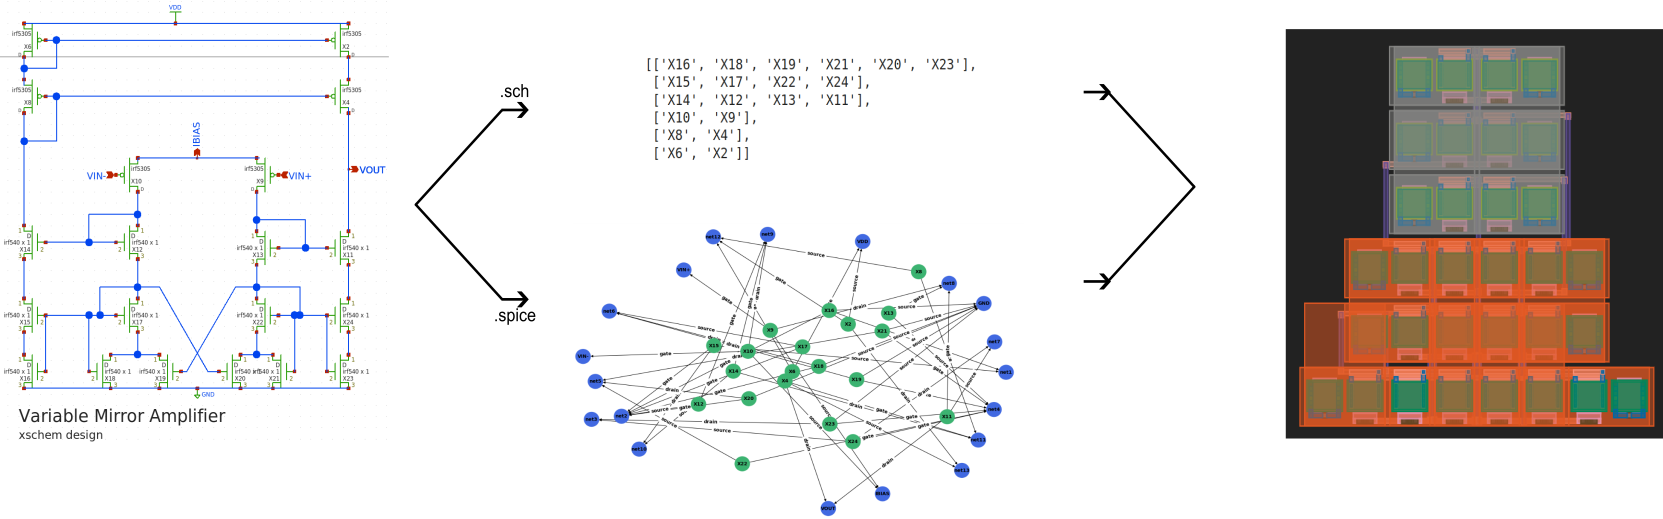

This project design started with the Miyahara circuit, as it was the chosen circuit for the SSCS'24 Chipathon. Once it was designed, I wanted to see if it could be generalized with the Fifty Nifty Paper circuits presented in the lectures, so you will find some of these designs in the folder as well. Since that worked, I didn't want to miss the opportunity to check other complex circuits like the Variable Mirror Amplifier (VMA). If you have your own design, please don't hesitate to test it!

So, in the following notebook I will explain the steps followed in order to obtain the layout with **(practically) any** design that can come to your minds!

The notebook is structured as follows:

1. **State of the art of automatic analog design**: Discusses how this notebook represents a step forward in open-source automatic analog design.

2. **Environment setup:** Includes several lines of code to prepare the environment. I designed everything in the Google Colab Notebook due to issues with installing the libraries on my PC. Despite this initial problem, using Google Colab demonstrates the powerful capabilities of the library and simplifies sharing between users, as it makes running the notebook locally more challenging.

3. **Manual design of the Miyahara circuit:** Provides a detailed look at the complexity of Python design for someone new in the field.

4. **Supporting functions:** Contains a series of functions used by the algorithm. These functions transform the input .sch and .spice files into useful information for the algorithm. I decided to hide them to keep the notebook organized, but feel free to open them and check the code!

5. **Algorithm functions for layout creation:** This section includes the functions that make up the algorithm dedicated to creating the layout. You will see up to eight versions, which I kept to show the mental process followed in the design and for educational purposes in layout design (I am not an expert in this field, so there is definitely room for improvement).

*Disclaimer: This project has been developed in just one month, therefore it is just the begining of a concept that seems promising. The tests that were carried have been just a small sample of what electronics is nowadays, for that reason there might be situations in which our functions don't operate as good as they should. Improvement needs to be done in order to make it generalizable.*

# 1. State of the art
Some papers have explored the automatic design of circuits. One of the first proposals was made in [1], where they designed parametrized generators based on input specifications. Later, in [2], the open-source community began to make strides thanks to Google's leadership and how the tools used in this project started to play a role in EDA design. This concept was applied in [3] as a temperature sensor generator in SkyWater 130 nm. Recently, in [4], the design process advanced further, allowing human commands to be written in text, which the algorithm could understand and use to create the layout.

Based on this recent development, and recognizing its impressive contribution, my experience as junior designer suggests that explaining the design needs to an AI in analog design is not always comfortable. We find a more engineer-oriented approach—using schematics and a table of specifications—makes, makes me feel more at ease and simplifies the design process enabling me more control of what I am actually doing.

In the development of analog layouts, recent advances have focused on automating the design process when changes are necessary, such as modifying transistor dimensions or even changing the PDK (Process Design Kit). However, for this automation to be feasible, an initial iteration must be carried out, which can take significant time to develop—up to two weeks, according to some estimates [5]. Therefore, the objective of this project is to reduce the time required to complete this first iteration by automating the placement and routing of the circuit. As a result, the design of an op-amp could potentially be completed in a matter of minutes.

References:


 [1] https://ieeexplore.ieee.org/document/8357061/

 [2] https://ieeexplore.ieee.org/document/9256818

 [3] https://ieeexplore.ieee.org/document/9816083

 [4] https://www.researchgate.net/publication/383875082_Human_Language_to_Analog_Layout_Using_GLayout_Layout_Automation_Framework

 [5] https://www.youtube.com/watch?v=Lim_A1x9yQM


# 2. Set up the environment

In [ ]:
#@title OpenFASOC GDSFactory generator
# You only need to run this block once!

# Clone OpenFASoC
!git clone https://github.com/idea-fasoc/OpenFASOC
# Install python dependencies
!pip install sky130
!pip install gf180 prettyprinttree svgutils
!pip install gdsfactory==7.7.0

import pathlib
import os
# Install KLayout (via conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
# Install from the litex-hub channel
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        klayout

In [3]:
#@title OpenFASOC GDSFactory generator II
# Adding micro-mamba binary directory to the PATH
# This directory contains Klayout
import pathlib
import os
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}
# Add conda packages to the PATH
PATH = os.environ['PATH']
%env PATH={PATH}:{CONDA_PREFIX}/bin

%cd /content/OpenFASOC/openfasoc/generators/glayout

env: CONDA_PREFIX=/content/conda-env
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/conda-env/bin
/content/OpenFASOC/openfasoc/generators/glayout


In [11]:
#@title Imports
from gdsfactory import Component
from glayout.flow.pdk.mappedpdk import MappedPDK
from glayout.flow.placement.two_transistor_interdigitized import two_nfet_interdigitized,two_pfet_interdigitized
from glayout.flow.pdk.util.comp_utils import prec_ref_center, movey, movex, evaluate_bbox
from glayout.flow.routing.smart_route import smart_route, c_route
from glayout.flow.primitives.fet import nmos,pmos
from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk

from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
from glayout.flow.pdk.gf180_mapped  import gf180_mapped_pdk  as gf180
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets
from glayout.flow.primitives.via_gen import via_stack
from gdsfactory.components import rectangle
import numpy as np

In [5]:
#@title Functions ONLY for GoogleColab

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

#  3. Manual design
Let's start first seeing how we would design the Miyahara comparator manually. It is important to have this starting point in order to see that even though in the long term is an automatic process, because we can change the width, lenght, the pdk (!the most important)... **the first design is basically hard coding**. By using this example, we can demonstrate how the project presented in this notebook enhances the current state of the art.

"From the main block presented in the following figure, we can identify a basic structure to build the circuit. The most fundamental concept we observe is a pair of transistors. It's important to note that we aren't referring to a differential pair, as there are three possible configurations.


*   Differential Pair
*   NMOS - NMOS Pair
*   PMOS - NMOS Pair

The concept is to develop a piece of code capable of creating different configurations. Based on these configurations, we can then add other transistors necessary to construct the Miyahara comparator. This building process will also streamline the creation of other comparators in a significantly shorter time frame.

From the image below, we can identify four stages/levels of code:

*   1rst purple: basic block of a pair of transistors each with diferent selectable properties
*   2nd green: to those basic blocks add some "spare" transistors which make the top and part of bottom circuit
*   3rd orange: finish builing the bottom circuit
*   4th blue: join top and bottom.
*   (not yet) 5th: build the external circuit - switching system



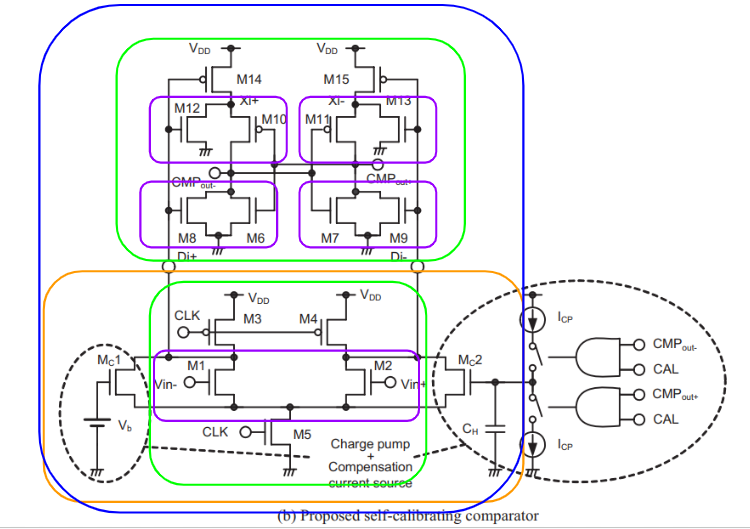



In [6]:
#Purple blocks main function
def TransistorPair(pdk: MappedPDK, type, same, width, length,portName):
    TransistorPair = Component(name="TransistorPair")

    '''
    Aquest bloc serveix com a base per al circuit, són els blocs liles
    Simplement son dos transistors connectats junts
    '''
    portNameP = portName + "_p_"
    portNameN = portName + "_n_"
    if same == True:
      if type == "PMOS":
          diffp = two_pfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffp_ref = prec_ref_center(diffp)
          TransistorPair.add(diffp_ref)
          TransistorPair.add_ports(diffp_ref.get_ports_list(), prefix=portNameP)
      if type == "NMOS":
          diffn = two_nfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffn_ref = prec_ref_center(diffn)
          TransistorPair.add(diffn_ref)
          TransistorPair.add_ports(diffn_ref.get_ports_list(), prefix=portNameN)
    else:
          diffp = two_pfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffn = two_nfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffp_ref = prec_ref_center(diffp)
          diffn_ref = prec_ref_center(diffn)
          TransistorPair.add(diffp_ref)
          TransistorPair.add(diffn_ref)

          movey(diffn_ref,-(evaluate_bbox(diffp)[1]/2+evaluate_bbox(diffn)[1]/2+pdk.util_max_metal_seperation()))
          TransistorPair.add_ports(diffp_ref.get_ports_list(), prefix=portNameP)
          TransistorPair.add_ports(diffn_ref.get_ports_list(), prefix=portNameN)
          #routing

          TransistorPair << smart_route(pdk, TransistorPair.ports[portNameP+"A_drain_E"], TransistorPair.ports[portNameN+"B_drain_E"])
          TransistorPair << smart_route(pdk, TransistorPair.ports[portNameP+"A_source_W"], TransistorPair.ports[portNameN+"B_source_W"])



    return TransistorPair

<ipython-input-28-fec2df97cb13>:10: UserWarning: Unnamed cells, 2 in 'TransistorPair$21'
  prueba_PMOSNMOS.write_gds('prueba_PMOSNMOS.gds')
2025-01-07 07:48:49.145 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'prueba_PMOSNMOS.gds'


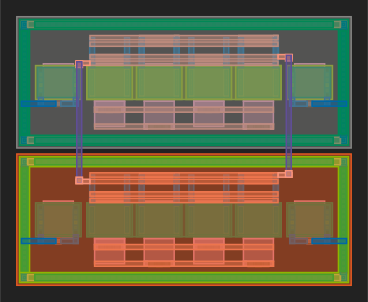

In [28]:
#Each type of purple block

# prueba_PMOS = TransistorPair(sky130_mapped_pdk, "PMOS", True, 2, 2,portName = "PMOS_PMOS")
# prueba_PMOS.write_gds('prueba_PMOS.gds')
# display_gds('prueba_PMOS.gds',scale=3)

# prueba_NMOS = TransistorPair(sky130_mapped_pdk, "NMOS", True, 2, 2,portName = "NMOS_NMOS")
# prueba_NMOS.write_gds('prueba_NMOS.gds')
# display_gds('prueba_NMOS.gds',scale=3)

prueba_PMOSNMOS = TransistorPair(sky130_mapped_pdk, "", False, 2, 2,portName = "PMOS_NMOS")
prueba_PMOSNMOS.write_gds('prueba_PMOSNMOS.gds')
display_gds('prueba_PMOSNMOS.gds',scale=1.5)

In [8]:
def HalfTopBlock(pdk: MappedPDK, width, length):
    HalfTopBlock = Component(name="HalfTopBlock")

    Spare_PMOS = pmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)
    TransistorPair_NMOSPMOS = TransistorPair(pdk, "", False, width, length,portName="NMOSPMOS")
    TransistorPair_NMOS = TransistorPair(pdk, "NMOS", True, width, length,portName = "NMOS_NMOS")

    TransistorPair_NMOSPMOS_ref = prec_ref_center(TransistorPair_NMOSPMOS)
    TransistorPair_NMOS_ref = prec_ref_center(TransistorPair_NMOS)
    Spare_PMOS_ref = prec_ref_center(Spare_PMOS)

    HalfTopBlock.add(TransistorPair_NMOSPMOS_ref)
    HalfTopBlock.add(TransistorPair_NMOS_ref)
    HalfTopBlock.add(Spare_PMOS_ref)

    movey(TransistorPair_NMOSPMOS_ref, evaluate_bbox(TransistorPair_NMOS)[1]/2+evaluate_bbox(TransistorPair_NMOSPMOS)[1]/2+pdk.util_max_metal_seperation())
    movey(Spare_PMOS_ref, evaluate_bbox(TransistorPair_NMOS)[1]/2+evaluate_bbox(TransistorPair_NMOSPMOS)[1]+evaluate_bbox(Spare_PMOS)[1]/2+2*pdk.util_max_metal_seperation())
    return HalfTopBlock

<ipython-input-27-dd307e3ded72>:2: UserWarning: Unnamed cells, 4 in 'HalfTopBlock$10'
  LeftTopBlock.write_gds('LeftTopBlock.gds')
2025-01-07 07:48:23.319 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'LeftTopBlock.gds'


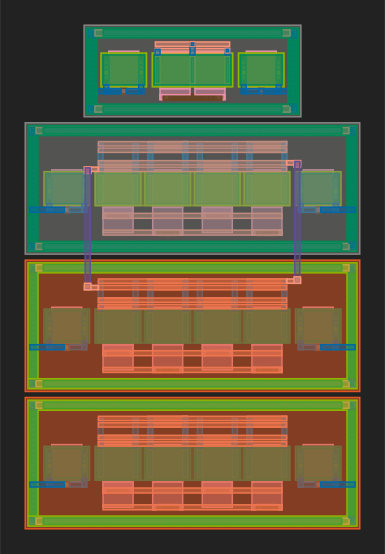

In [27]:
LeftTopBlock = HalfTopBlock(sky130_mapped_pdk,2,2)
LeftTopBlock.write_gds('LeftTopBlock.gds')
display_gds('LeftTopBlock.gds',scale=1.5)

In [13]:
def TopBlock(pdk: MappedPDK, width, length):
    TopBlock = Component(name="TopBlock")

    HalfTopBlock_Left = HalfTopBlock(pdk, width, length)
    HalfTopBlock_Right = HalfTopBlock(pdk, width, length)


    HalfTopBlock_Left_ref = prec_ref_center(HalfTopBlock_Left)
    HalfTopBlock_Right_ref = prec_ref_center(HalfTopBlock_Right)


    TopBlock.add(HalfTopBlock_Left_ref)
    TopBlock.add(HalfTopBlock_Right_ref)

    movex(HalfTopBlock_Right_ref, evaluate_bbox(HalfTopBlock_Left)[0]/2+evaluate_bbox(HalfTopBlock_Right)[0]/2+pdk.util_max_metal_seperation())
    return TopBlock

<ipython-input-24-f23a32ddcdce>:2: UserWarning: Unnamed cells, 8 in 'TopBlock$3'
  TopBlock_component.write_gds('TopBlock.gds')
2025-01-07 07:47:06.583 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'TopBlock.gds'


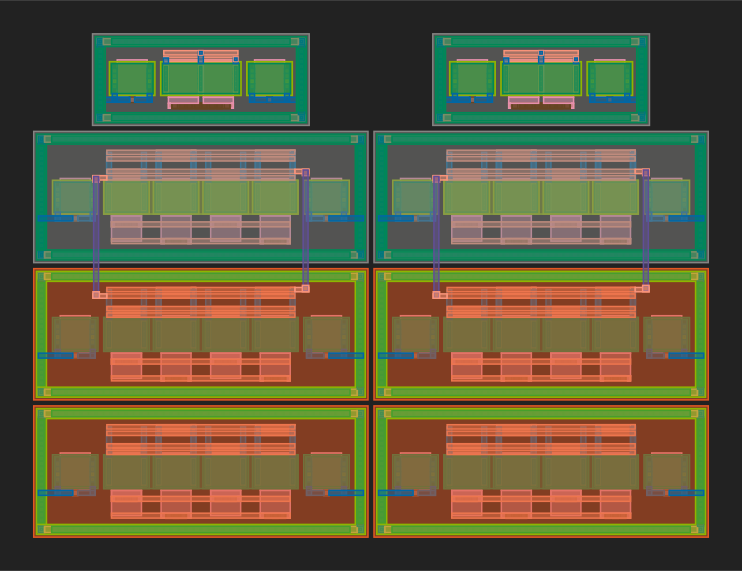

In [24]:
TopBlock_component = TopBlock(sky130_mapped_pdk,2,2)
TopBlock_component.write_gds('TopBlock.gds')
display_gds('TopBlock.gds',scale=1.5)

In [16]:
def HalfBottomBlock(pdk: MappedPDK, width, length):
    HalfBottomBlock = Component(name="HalfBottomBlock")

    Spare_PMOS = pmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)
    Spare_NMOS = nmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)

    Spare_PMOS_ref = prec_ref_center(Spare_PMOS)
    Spare_NMOS_ref = prec_ref_center(Spare_NMOS)

    HalfBottomBlock.add(Spare_PMOS_ref)
    HalfBottomBlock.add(Spare_NMOS_ref)

    movey(Spare_PMOS_ref, evaluate_bbox(Spare_PMOS)[1]/2+evaluate_bbox(Spare_NMOS)[1]/2+pdk.util_max_metal_seperation())

    return HalfBottomBlock

<ipython-input-25-ff9012412061>:2: UserWarning: Unnamed cells, 2 in 'HalfBottomBlock$7'
  HalfBottomBlock_component.write_gds('HalfBottomBlock.gds')
2025-01-07 07:47:16.736 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'HalfBottomBlock.gds'


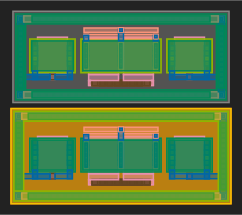

In [25]:
HalfBottomBlock_component = HalfBottomBlock(sky130_mapped_pdk,2,2)
HalfBottomBlock_component.write_gds('HalfBottomBlock.gds')
display_gds('HalfBottomBlock.gds',scale=1.5)

In [18]:
def BottomBlock(pdk: MappedPDK, width, length):
    BottomBlock = Component(name="BottomBlock")

    HalfBottomBlock_Left = HalfBottomBlock(pdk, width, length)
    HalfBottomBlock_Right = HalfBottomBlock(pdk, width, length)
    Spare_NMOS = nmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)

    HalfBottomBlock_Left_ref = prec_ref_center(HalfBottomBlock_Left)
    HalfBottomBlock_Right_ref = prec_ref_center(HalfBottomBlock_Right)
    Spare_NMOS_ref = prec_ref_center(Spare_NMOS)

    BottomBlock.add(HalfBottomBlock_Left_ref)
    BottomBlock.add(HalfBottomBlock_Right_ref)
    BottomBlock.add(Spare_NMOS_ref)

    movey(Spare_NMOS_ref, -(evaluate_bbox(HalfBottomBlock_Left)[1]/2+evaluate_bbox(Spare_NMOS)[1]/2+pdk.util_max_metal_seperation()))
    movex(Spare_NMOS_ref, 0.5*(evaluate_bbox(HalfBottomBlock_Left)[0]/2+evaluate_bbox(HalfBottomBlock_Right)[0]/2+pdk.util_max_metal_seperation()))
    movex(HalfBottomBlock_Right_ref, evaluate_bbox(HalfBottomBlock_Left)[0]/2+evaluate_bbox(HalfBottomBlock_Right)[0]/2+pdk.util_max_metal_seperation())

    return BottomBlock

<ipython-input-26-6d3b7827e611>:2: UserWarning: Unnamed cells, 5 in 'BottomBlock$3'
  BottomBlock_component.write_gds('BottomBlock.gds')
2025-01-07 07:47:41.799 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'BottomBlock.gds'


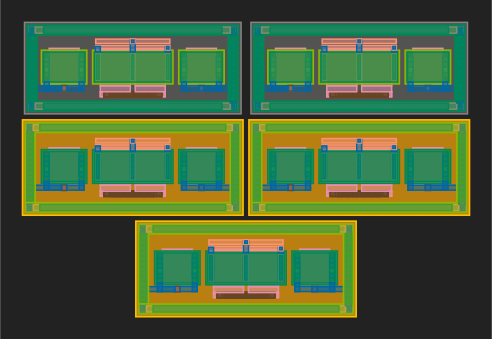

In [26]:
BottomBlock_component = BottomBlock(sky130_mapped_pdk,2,2)
BottomBlock_component.write_gds('BottomBlock.gds')
display_gds('BottomBlock.gds',scale=1.5)

In [20]:
def MiyaharaBlock(pdk: MappedPDK, width, length):
    MiyaharaBlock = Component(name="MiyaharaBlock")

    HalfMiyaharaBlock_Top = TopBlock(pdk, width, length)
    HalfMiyaharaBlock_Bottom = BottomBlock(pdk, width, length)

    HalfMiyaharaBlock_Top_ref = prec_ref_center(HalfMiyaharaBlock_Top)
    HalfMiyaharaBlock_Bottom_ref = prec_ref_center(HalfMiyaharaBlock_Bottom)

    MiyaharaBlock.add(HalfMiyaharaBlock_Top_ref)
    MiyaharaBlock.add(HalfMiyaharaBlock_Bottom_ref)

    movey(HalfMiyaharaBlock_Top_ref, evaluate_bbox(HalfMiyaharaBlock_Top)[1]/2+evaluate_bbox(HalfMiyaharaBlock_Bottom)[1]/2+pdk.util_max_metal_seperation())

    return MiyaharaBlock

<ipython-input-23-4d36ba529155>:2: UserWarning: Unnamed cells, 13 in 'MiyaharaBlock$1'
  MiyaharaBlock_component.write_gds('MiyaharaBlock.gds')
2025-01-07 07:43:59.332 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'MiyaharaBlock.gds'


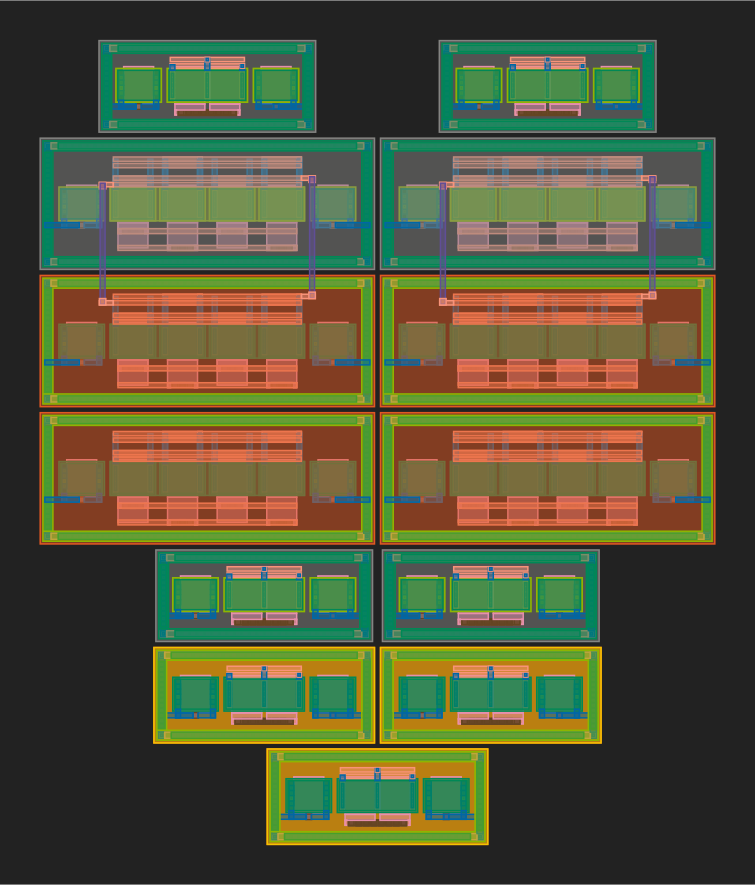

In [23]:
MiyaharaBlock_component = MiyaharaBlock(sky130_mapped_pdk,2,2)
MiyaharaBlock_component.write_gds('MiyaharaBlock.gds')
display_gds('MiyaharaBlock.gds',scale=1.5)

The routing of the system level is missing but it would be done with smart_route

# 4. Extract required data

The first step for a designer is to create the architecture design, which involves choosing the schematic for each block. For this purpose, I used xschem. From that, I extracted two essential files: .sch and .spice. With these files, I can gather all the required information to design an automatic layout.

### Schematic
As mentioned before, the area is not a specification considered in this project, based on the available examples where it didn't seem to be a focus either. Given this, we aimed to replicate the placement of transistors from the schematic design into the layout. The exact positions aren't crucial for us; what matters is the relative placement, such as which transistor is on top, which is on the bottom, and which transistors are paired next to each other.

*Disclaimer: This is one aspect that can be improved in the future. With knowledge of the wiring, we could place the transistors in a more optimal way. However, due to time constraints, this was not implemented.*

In [ ]:
#@title Functions: preprocess_file(file_name) and parse_transistor_file(file_name, sort_by='x')
import pandas as pd

def preprocess_file(file_name):
    #the file comes with new lines but without sense, so we convert that into one line with all the transistor information
    with open(file_name, 'r') as file:
        lines = file.readlines()

    # Join lines that are split across multiple lines and keep only relevant lines
    joined_lines = []
    current_line = ""
    for line in lines:
        #Here we must add new type of transitors being used
        if line.startswith('C {pmos3.sym}') or line.startswith('C {nmos3.sym}') or line.startswith('C {gnd.sym}') or line.startswith('C {opin.sym}') or line.startswith('C {ipin.sym}')or line.startswith('C {nmos.sym}') or line.startswith('C {pmos.sym}') or line.startswith('C {lab_pin.sym}') or line.startswith('C {vdd.sym}') or line.startswith('C {gnd.sym}'):
            if current_line:
                joined_lines.append(current_line)
            current_line = line.strip()
        elif current_line:
            current_line += " " + line.strip()
    if current_line:
        joined_lines.append(current_line)

    return joined_lines

def parse_transistor_file(file_name, sort_by='x'):
    transistors = []
    lines = preprocess_file(file_name)
    for line in lines:
        parts = line.split()
        if line.startswith('C {pmos3.sym}') or line.startswith('C {nmos3.sym}') or line.startswith('C {nmos.sym}') or line.startswith('C {pmos.sym}'):
            transistor_type = 'nmos' if ('nmos3.sym' in parts[1] or 'nmos.sym' in parts[1]) else 'pmos'
            x_coord = int(parts[2])
            y_coord = int(parts[3])
            # Convert parts to a dictionary because the pmos and nmos don't have the same amount of attributes and we
            # cannot acces to them by position, so using a dictionary is the best method
            attributes = {}
            for part in parts[5:]:
                if '=' in part:
                    key, value = part.split('=')
                    attributes[key] = value.rstrip('}')
            #we need to clean it since it wasn't a dictionary by itself, python does not understand it unless we
            #remove the extra '' and {}
            cleaned_dict = {key.replace("'", "").replace("{", ""): value.replace("'", "") for key, value in attributes.items()}
            name = cleaned_dict.get('name', 'Unknown')
            m_value = cleaned_dict.get('m', '2')  # Default to '1' if 'm' is not found

            transistors.append([name, transistor_type, x_coord, y_coord, m_value])

    df = pd.DataFrame(transistors, columns=['Name', 'Type', 'X', 'Y', 'M'])
    sort_by = sort_by.upper()
    df = df.sort_values(by=sort_by,ascending=False)
    return df

This code processes transistor data by first reading and merging relevant lines (chosen by the designer) into single lines using *preprocess_file*. Then, *parse_transistor_file* extracts details such as type, coordinates, and attributes, organizing them into a pandas DataFrame. Finally, it sorts the data based on a specified coordinate for easy access and analysis.

In [ ]:
#@title sort_positions
def sort_positions(df):
  # Convert the list of dictionaries to a DataFrame
  df = pd.DataFrame(df)

  # Calculate the tolerance for x and y
  x_tolerance = df['X'].mean() * 0.2
  y_tolerance = df['Y'].mean() * 0.2

  # Round x and y values based on tolerance
  df['X'] = df['X'].apply(lambda x: round(x / x_tolerance) * x_tolerance)
  df['Y'] = df['Y'].apply(lambda y: round(y / y_tolerance) * y_tolerance)

  # Sort the DataFrame by y in descending order and x in ascending order
  df_sorted = df.sort_values(by=['Y', 'X'], ascending=[False, True])

  # Group by 'Y' and aggregate 'Name' into lists
  grouped = df_sorted.groupby('Y')['Name'].apply(list).reset_index()

  # Return the 'Name' lists within a list
  return grouped['Name'].tolist()[::-1]

This code organizes transistor positions by rounding their coordinates to group them, sorting by y (descending) and x (ascending). It then groups transistors with the same y coordinate and returns a list of their names. The designer can modify the tolerance used to consider that two transistors are in the same row

### Netlist
Using the netlist information, we gather data about the connections of each transistor. With this knowledge, we create a graph representing the entire circuit, which helps us automatically connect all the required nodes when designing the layout. The graph is plotted for illustrative purposes.

In [ ]:
#@title extract_transistor_data_from_file
def extract_transistor_data_from_file(file_path):
    """
    Extracts transistor data from the given file and returns a DataFrame.

    Parameters:
    file_path (str): The path to the input file.

    Returns:
    pd.DataFrame: A DataFrame with columns ["Trt", "D", "G", "S", "Type"].
    """
    # Read the file content
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter lines that start with 'M'
    filtered_lines = [line.strip() for line in lines if line.startswith('M') or line.startswith('X')] #Can be modified by the desginer with the names of the transistors that is using

    # Extract the relevant parts and create a DataFrame
    data_list = []
    for line in filtered_lines:
        parts = line.split()
        data_list.append(parts[:5])  # Extract the first 5 elements

    # Create the DataFrame
    df = pd.DataFrame(data_list, columns=["Trt", "D", "G", "S", "Type"])

    return df

This code reads a file to extract transistor data and organizes it into a pandas DataFrame. It starts by reading the file's content and filtering lines that begin with 'M' or 'X' (in this case were the initial names of the transistors). It then processes these lines, extracting key details (the first five elements) and creates a DataFrame with columns "Trt" (transistor), "D" (drain), "G" (gate), "S" (source), and "Type", representing different transistor attributes.

#### Graph theory to obtain connections
Multiple python libraries were tested to create a grapho, however "networkx" was finally chosen since it did not require an account in the platform.

Two types of nodes were created: transistors and wires. Transistor nodes have a property indicating whether they are PMOS or NMOS. Both types of nodes are connected by edges that indicate whether the connection is a gate, source, or drain, depending on which pin of the transistor the wire is connected to.

In [ ]:
#@title Install and imports
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#@title create_grapho(netlist, k_value=0.3, fig_size=(12, 8))
import networkx as nx
import matplotlib.pyplot as plt

def create_grapho(netlist, k_value=0.3, fig_size=(12, 8)):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with their properties
    for trt, typ, d, g, s in zip(netlist['Trt'], netlist['Type'], netlist['D'], netlist['G'], netlist['S']):
        G.add_node(trt, type='transistor', spec=typ)
        G.add_node(d, type='wire')
        G.add_node(g, type='wire')
        G.add_node(s, type='wire')

    # Add edges based on connections
    for trt, d, g, s in zip(netlist['Trt'], netlist['D'], netlist['G'], netlist['S']):
        G.add_edge(trt, d, connection='drain')
        G.add_edge(trt, g, connection='gate')
        G.add_edge(trt, s, connection='source')

    # Set the figure size
    plt.figure(figsize=fig_size)

    # Draw the graph
    pos = nx.spring_layout(G, k=k_value)  # Adjust k value as needed
    color_map = {'transistor': 'mediumseagreen', 'wire': 'royalblue'}
    node_colors = [color_map[G.nodes[node]['type']] for node in G.nodes]
    edge_colors = ['black']

    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors,
            font_size=10, font_color='black', edge_color=edge_colors,
            node_shape='o', edge_cmap=plt.cm.Blues, font_weight='bold')

    # Draw edge labels
    edge_labels = {(u, v): d['connection'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_weight='bold')

    plt.title('Netlist Graph')
    plt.show()
    return G

This code creates and visualizes a directed graph representing a netlist of transistors and their connections. It does this by first adding nodes for each transistor and wire, along with their properties, then connecting these nodes with edges based on the gate, source, and drain connections. The graph is then drawn using matplotlib, with nodes and edges color-coded for clarity (following the schematic colors). Finally, it plots the graph.

In [ ]:
#@title find_connections(graph, node_type1, node_type2)
def find_connections(graph, node_type1, node_type2):
    connections = set()
    for node in graph.nodes:
        if graph.nodes[node]['type'] == node_type1:
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['type'] == node_type2:
                    for second_neighbor in graph.neighbors(neighbor):
                        if graph.nodes[second_neighbor]['type'] == node_type1 and second_neighbor != node:
                            edge_name1 = graph.get_edge_data(node, neighbor)['connection']
                            edge_name2 = graph.get_edge_data(second_neighbor, neighbor)['connection']
                            connection = tuple(sorted([node, second_neighbor])) + (neighbor, tuple(sorted([edge_name1, edge_name2])))
                            connections.add(connection)
    return connections


Identifies and returns connections between two specified types of nodes in a graph.

In [ ]:
#@title find_wire_connections(graph, wire_type, transistor_type)
def find_wire_connections(graph, wire_type, transistor_type):
    wire_connections = {}
    for node in graph.nodes:
        if graph.nodes[node]['type'] == wire_type:
            wire_connections[node] = {}
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['type'] == transistor_type:
                    edge_name = graph.get_edge_data(node, neighbor)['connection']
                    wire_connections[node][neighbor] = edge_name
    return wire_connections

Identifies and returns connections between wires and transistors in a graph. For each of these connections, it records the type of connection (e.g., gate, source, drain) in a dictionary, which maps each wire to its connected transistors and their respective connection types.

**!** *find_connections* is more about finding relationships between two nodes of the same type through an intermediate node, while *find_wire_connections* focuses on mapping direct connections between wires and transistors.

# 5. Automatic test Netlist-GLayout
To get to the final (for now) version of my code, I went through numerous steps. This wasn't just about resolving coding errors, but rather developing the pipeline required for the automatic creation of an analog layout. For this reason, analyzing the evolution of layout design is particularly interesting. The images below showcase the various versions that have been developed. For those interested in a deeper dive, the code is available to examine the iterative improvements made in each version. This progression not only highlights technical advancements but also reflects a dedication to continuous improvement and excellence in design.

In [ ]:
#@title PlaceTransistor(pdk: MappedPDK, type, width, length,portName,with_dummy)
from glayout.flow.primitives.fet import nmos,pmos
"""
    Generic NMOS generator
    pdk: mapped pdk to use
    width: expands the NMOS in the y direction
    fingers: introduces additional fingers (sharing source/drain) of width=width
    multipliers: number of multipliers (a multiplier is a row of fingers)
    with_tie: true or false, specfies if a bulk tie is required
    with_dummy: tuple(bool,bool) or bool specifying both sides dummy or neither side dummy
    ****using the tuple option, you can specify a single side dummy such as true,false
    with_dnwell: bool use dnwell (multi well)
    with_substrate_tap: add substrate tap on the very outside perimeter of nmos
    length: if None or below min_length will default to min_length
    sd_route_topmet: specify top metal glayer for the source/drain route
    gate_route_topmet: specify top metal glayer for the gate route
    sd_route_left: specify if the source/drain inter-multiplier routes should be on the left side or right side (if false)
    rmult: if not None overrides all other multiplier options to provide a simple routing multiplier (int only)
    sd_rmult: mulitplies the thickness of the source drain route (int only)
    gate_rmult: add additional via rows to the gate route via array (int only)
    interfinger_rmult: multiplies the thickness of the metal routes between the fingers (int only)
    tie_layers: tuple[str,str] specifying (horizontal glayer, vertical glayer) or well tie ring. default=("met2","met1")
    substrate_tap_layers: tuple[str,str] specifying (horizontal glayer, vertical glayer) or substrate tap ring. default=("met2","met1")
    dummy_routes: bool default=True, if true add add vias and short dummy poly,source,drain
    """
def PlaceTransistor(pdk: MappedPDK, type, width, length,portName,with_dummy):
  PlaceTransistor = Component(name="PlaceTransistor")
  if type == "pmos":
    diffp = pmos(pdk, width=width, length=length,with_substrate_tap=False,with_tie=False,with_dummy=with_dummy)
  elif type == "nmos":
    diffp = nmos(pdk, width=width, length=length,with_tie=False,with_dnwell=False,with_substrate_tap=False,with_dummy=with_dummy)
  diffp_ref = prec_ref_center(diffp)
  PlaceTransistor.add(diffp_ref)
  PlaceTransistor.add_ports(diffp_ref.get_ports_list(), prefix=portName)
  return PlaceTransistor

Generates a transistor component, either NMOS or PMOS, based on the provided parameters. The function utilizes the pdk, type, width, length, portName, and with_dummy arguments to configure the transistor. The appropriate transistor (NMOS or PMOS) is created with specified properties and added to the PlaceTransistor component, which also incorporates the transistor's ports with a given prefix.

The images below demonstrate the progression and improvement of the design, in this case I have worked with the Miyahara comparator. In yellow, the issues of each version are highlighted, while in green, the solutions to the previous version's problems are shown. It is recommended to rerun the code to clearly see the changes in the latest versions, as the details may be small in the images.

* **v0**: The design began with the placement of transistors and wire connections, which had some problems.

* **v1**: Improvements were made by centering the placement of the transistors, allowing better connectivity between elements.

* **v2**: Dummy transistors were added to the edges of the design, providing uniformity in the manufacturing process and mitigating stress.

* **v3**: o comply with the DRC rule that requires a minimum separation between n-wells (grulesobj["nwell"]["nwell"] = {"min_width": 0.84, "min_separation": 1.27}), instead of adding more separation between transistors, in rows with only PMOS or NMOS (eventhough there is no restriction on p-well distance) transistors, a rectangle was created.

* **v4**: For rows containing both PMOS and NMOS transistors, a rectangle was created.

* **v5**: The previous problem was tackled to the y-axis. Vertical rectangles were created while considering the possibility of having different transistor types above each other across the x-range.

* **v6**: Vertical rectangles were adjusted to address small empty spaces created when two vertical rectangles were adjacent. These spaces needed to be removed.

* **v7**: Improvements needed will be mentioned in the project's conclusion.

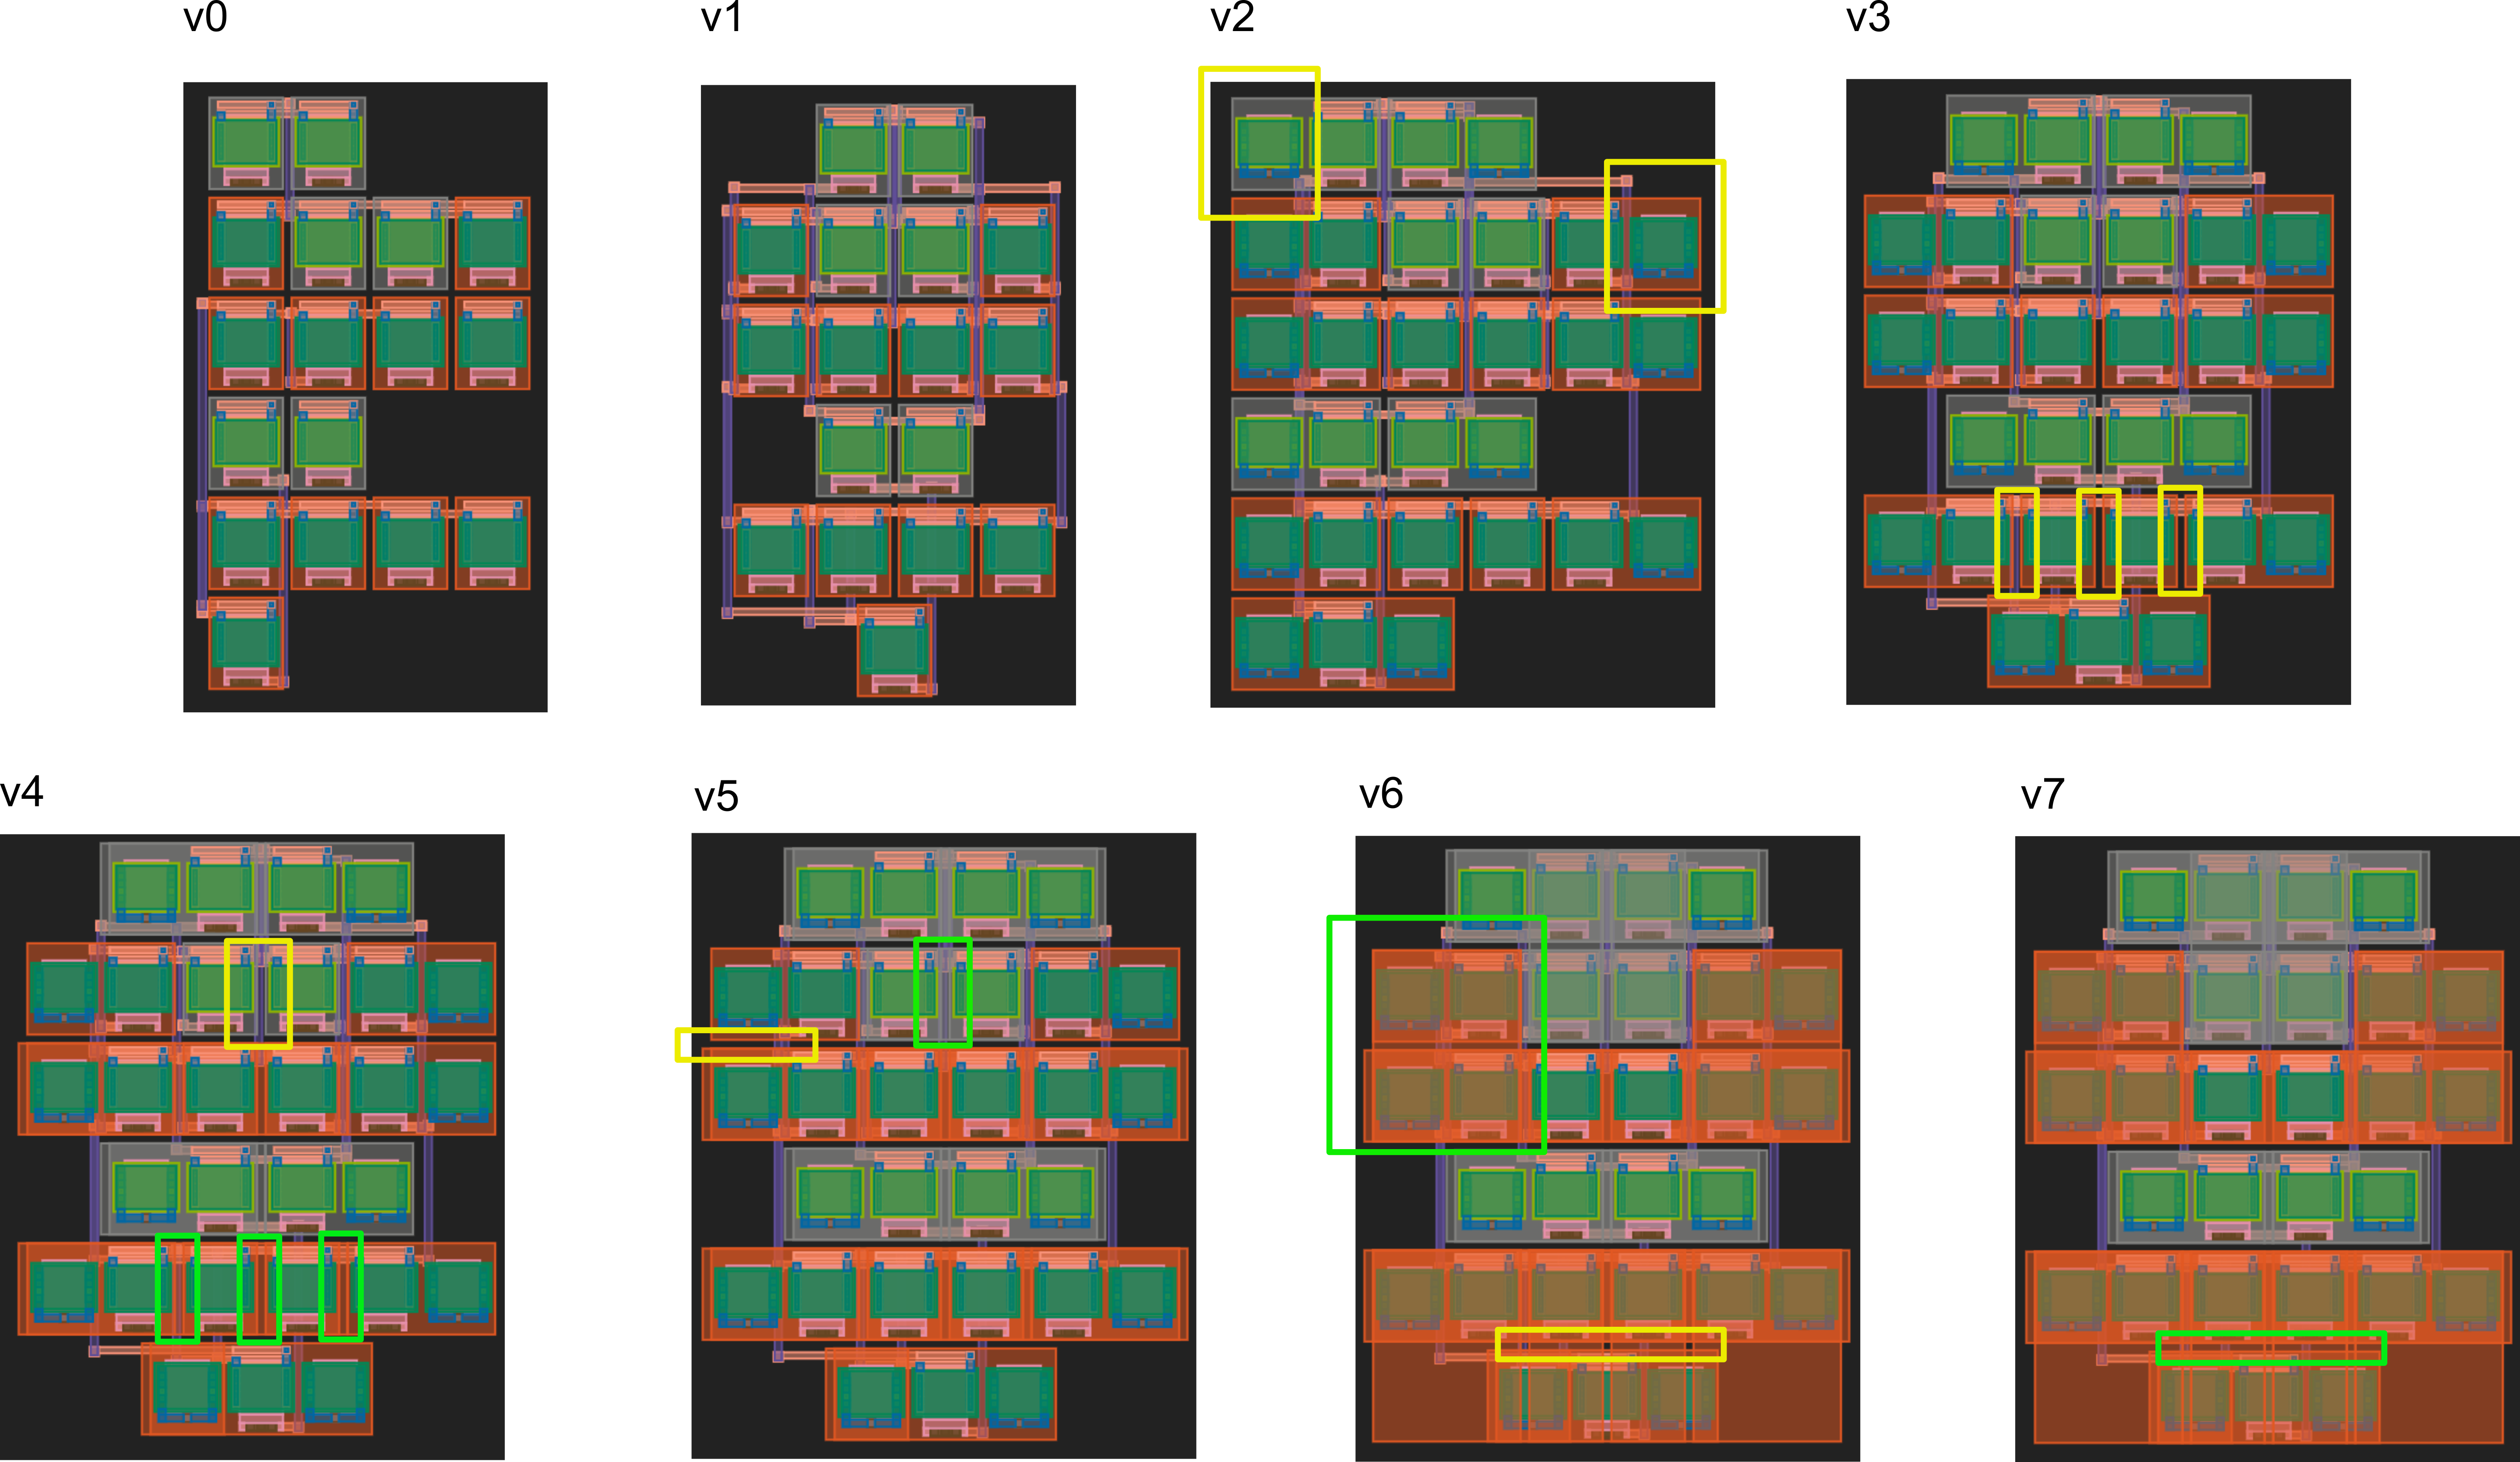

### Previous versions

In [ ]:
#@title v.0

def create_layout(pdk: MappedPDK, width, length,sorted_positions, info_transistors,connections): # Function to create the overall layout
  all_layout = Component(name='final_layout') # Create a component to hold the entire layout
  results = {} # Initialize an empty dictionary to store intermediate results
  y_position = 0 # Initialize the y-coordinate for placing transistors
  for row in sorted_positions: # Iterate over each row of transistors
    print(row)
    x_position = 0 # Initialize the x-coordinate for placing transistors in the current row
    for transistor_name in row: # Iterate over each transistor in the current row
      print(transistor_name)
      key = f"{transistor_name}"
      type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] # Get the type of the current transistor
      results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name,with_dummy=False)
      results[f"{key}_ref"] = prec_ref_center(results[key])
      all_layout.add(results[f"{key}_ref"])
      movey(results[f"{key}_ref"], y_position) # Move the transistor to the correct y-coordinate
      movex(results[f"{key}_ref"], x_position) # Move the transistor to the correct x-coordinate

      x_position += results[key].size[0] + pdk.util_max_metal_seperation()# Update the x-coordinate for the next transistor in the row
    y_position += results[key].size[1] + pdk.util_max_metal_seperation() # Update the y-coordinate for the next row

  wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
  counter = 0
  for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
          for transistor in list(A.keys()):
              suffix = "_W" if counter % 2 == 0 else "_E"
              ports.append(results[f"{transistor}_ref"].ports[transistor + A[transistor] + suffix])  # You can choose the metal layer with layer=pdk.get_glayer("met2")
          counter += 1
          for i in range(0, len(ports), 5):
              group_ports = ports[i:i + 5]
              if len(group_ports) > 1:
                  all_layout.add(smart_route(pdk, *group_ports))

  return all_layout # Return the complete layout

In [ ]:
#@title v.1
def create_layout(pdk: MappedPDK, width, length,sorted_positions, info_transistors,connections): # Function to create the overall layout
  all_layout = Component(name='final_layout') # Create a component to hold the entire layout
  results = {} # Initialize an empty dictionary to store intermediate results
    # Calculate total width and height of layout
  total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
  total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0],with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

  # Initial y_position adjusted to center layout vertically
  y_position = (total_height - sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0],with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])) / 2

  for row in sorted_positions:
      # Initial x_position adjusted to center layout horizontally for each row
    x_position = (total_width - sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])) / 2
    for transistor_name in row: # Iterate over each transistor in the current row
      print(transistor_name)
      key = f"{transistor_name}"
      type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] # Get the type of the current transistor
      results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name,with_dummy=False)
      results[f"{key}_ref"] = prec_ref_center(results[key])
      all_layout.add(results[f"{key}_ref"])

      #RULES
      viam2m3 = via_stack(pdk,"met2","met3",centered=True)
      metal_min_dim = max(pdk.get_grule("met2")["min_width"],pdk.get_grule("met3")["min_width"])
      metal_space = max(pdk.get_grule("met2")["min_separation"],pdk.get_grule("met3")["min_separation"],metal_min_dim)
      gate_route_os = evaluate_bbox(viam2m3)[0]- results[key].ports[key+"multiplier_0_gate_W"].width + metal_space
      min_spacing_y = metal_space + 2*gate_route_os
      min_spacing_y = min_spacing_y - 2*abs(results[key].ports[key+"well_S"].center[1] - results[key].ports[key+"multiplier_0_gate_S"].center[1])


      movey(results[f"{key}_ref"], y_position) # Move the transistor to the correct y-coordinate
      movex(results[f"{key}_ref"], x_position) # Move the transistor to the correct x-coordinate
      x_position += results[key].size[0] + pdk.util_max_metal_seperation() # Update the x-coordinate for the next transistor in the row
    y_position += results[key].size[1] + pdk.util_max_metal_seperation() # Update the y-coordinate for the next row


  wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
  counter = 0
  for wire, A in wire_connections.items():
    ports = []
    if len(list(A.keys())) > 1:
      for transistor in list(A.keys()):
        suffix = "_W" if counter % 2 == 0 else "_E"
        """
        args:
        pdk = pdk to use
        edge1 = first port
        edge2 = second port
        vwidth = optional will default to vertical edge width if None
        hwidth = optional will default to horizontal edge width if None
        hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
        vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
        viaoffset = push the via away from both edges so that inside corner aligns with via corner
        ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
        fullbottom = fullbottom option for via
        """
        ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
      counter += 1
      #edges = alternate_edges(ports)
      for i in range(len(ports) - 1):
        all_layout.add(smart_route(pdk, ports[i],ports[i+1]))


  #estaria bé posar un substrate tap per transistors, si tenim dos pmos junts doncs fer-lo comu... etc

  return all_layout # Return the complete layout

In [ ]:
#@title v.2
def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    # Function to create the overall layout
    all_layout = Component(name='final_layout')  # Create a component to hold the entire layout
    results = {}  # Initialize an empty dictionary to store intermediate results
    y_position = 0 # Initialize the y-coordinate for placing transistors
    # Initial y_position adjusted to center layout vertically

#····································································································································································

    for row in sorted_positions:
        x_position = 0
        prev_dim = 0
        for i, transistor_name in enumerate(row):  # Iterate over each transistor in the current row
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]  # Get the type of the current transistor
            with_dummy = (False, False)
            number_dummies = 0
            if len(row) == 1:  # Single transistor in row
                with_dummy = (True,True)
                number_dummies = 2
            elif i == 0:  # First transistor in row
                with_dummy = (True, False)
                number_dummies = 1
            elif i == len(row) - 1:  # Last transistor in row
                with_dummy = (False, True)
                number_dummies = 1
            # Create the transistor with the dummy settings
            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            # RULES
            viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
            metal_min_dim = max(pdk.get_grule("met2")["min_width"], pdk.get_grule("met3")["min_width"])
            metal_space = max(pdk.get_grule("met2")["min_separation"], pdk.get_grule("met3")["min_separation"], metal_min_dim)
            gate_route_os = evaluate_bbox(viam2m3)[0] - results[key].ports[key + "multiplier_0_gate_W"].width + metal_space
            min_spacing_y = metal_space + 2 * gate_route_os
            min_spacing_y = min_spacing_y - 2 * abs(results[key].ports[key + "well_S"].center[1] - results[key].ports[key + "multiplier_0_gate_S"].center[1])


            x_position += prev_dim + results[key].size[0]/2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0]/2

            movey(results[f"{key}_ref"], y_position)  # Move the transistor to the correct y-coordinate
            movex(results[f"{key}_ref"], x_position)  # Move the transistor to the correct x-coordinate

            #TO DO THE UPDATE WE MUST TAKE INTO CONSIDERATION THE ACTUAL AND NEXT ELEMENT
            #x_position += results[key].size[0] + pdk.util_max_metal_seperation() # Update the x-coordinate for the next transistor in the row
        y_position += results[key].size[1] + pdk.util_max_metal_seperation()  # Update the y-coordinate for the next row

#····································································································································································

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

#····································································································································································

    return all_layout  # Return the complete layout

In [ ]:
#@title v.3

def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    # Function to create the overall layout
    all_layout = Component(name='final_layout')  # Create a component to hold the entire layout
    results = {}  # Initialize an empty dictionary to store intermediate results
    y_position = 0 # Initialize the y-coordinate for placing transistors
    # Initial y_position adjusted to center layout vertically
    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0],with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

#····································································································································································

    for row in sorted_positions:
        #x_position = 0
        prev_dim = 0
      # Initial x_position adjusted to center layout horizontally for each row
        x_position = (total_width - sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])) / 2

        for i, transistor_name in enumerate(row):  # Iterate over each transistor in the current row
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]  # Get the type of the current transistor
            with_dummy = (False, False)
            number_dummies = 0
            if len(row) == 1:  # Single transistor in row
                with_dummy = (True,True)
                number_dummies = 2
            elif i == 0:  # First transistor in row
                with_dummy = (True, False)
                number_dummies = 1
            elif i == len(row) - 1:  # Last transistor in row
                with_dummy = (False, True)
                number_dummies = 1
            # Create the transistor with the dummy settings
            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            # RULES
            viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
            metal_min_dim = max(pdk.get_grule("met2")["min_width"], pdk.get_grule("met3")["min_width"])
            metal_space = max(pdk.get_grule("met2")["min_separation"], pdk.get_grule("met3")["min_separation"], metal_min_dim)
            gate_route_os = evaluate_bbox(viam2m3)[0] - results[key].ports[key + "multiplier_0_gate_W"].width + metal_space
            min_spacing_y = metal_space + 2 * gate_route_os
            min_spacing_y = min_spacing_y - 2 * abs(results[key].ports[key + "well_S"].center[1] - results[key].ports[key + "multiplier_0_gate_S"].center[1])


            x_position += prev_dim + results[key].size[0]/2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0]/2

            movey(results[f"{key}_ref"], y_position)  # Move the transistor to the correct y-coordinate
            movex(results[f"{key}_ref"], x_position)  # Move the transistor to the correct x-coordinate

            #TO DO THE UPDATE WE MUST TAKE INTO CONSIDERATION THE ACTUAL AND NEXT ELEMENT
            #x_position += results[key].size[0] + pdk.util_max_metal_seperation() # Update the x-coordinate for the next transistor in the row
        y_position += results[key].size[1] + pdk.util_max_metal_seperation()  # Update the y-coordinate for the next row

#····································································································································································

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

#····································································································································································

    return all_layout  # Return the complete layout

In [ ]:
#@title v.4

def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    y_position = 0
    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    for row in sorted_positions:
        row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
        x_position = (total_width - row_width) / 2
        x_position_init = (total_width - row_width) / 2
        prev_dim = 0

         # Check if all transistors in the row are the same type
        row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row]
        if all(t == row_types[0] for t in row_types):
            # Get coordinates to create a rectangle
            row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]  #ens es indiferent si hi han dummies o no
            rectangle_dimensions = (row_width, row_height)
            if row_types[0] == "pmos":
                rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
            elif row_types[0] == "nmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
            rectangle_ref = all_layout << rectangle
            #all_layout.add(rectangle)
            movey(rectangle_ref, y_position-row_height/2)  # Adjust y_position to place rectangle below transistors
            movex(rectangle_ref, x_position_init)  # Adjust y_position to place rectangle below transistors

        for i, transistor_name in enumerate(row):
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
            with_dummy = (False, False)
            if len(row) == 1:
                with_dummy = (True, True)
            elif i == 0:
                with_dummy = (True, False)
            elif i == len(row) - 1:
                with_dummy = (False, True)

            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            x_position += prev_dim + results[key].size[0] / 2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0] / 2
            movey(results[f"{key}_ref"], y_position)
            movex(results[f"{key}_ref"], x_position)

        y_position += results[key].size[1] + pdk.util_max_metal_seperation()

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

    return all_layout

def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level

In [ ]:
#@title v.5

def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    y_position = 0
    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    for row in sorted_positions:
        row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
        x_position = (total_width - row_width) / 2
        prev_dim = 0

        row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row]

        # Check if all transistors in the row are the same type
        if all(t == row_types[0] for t in row_types):
            # Get coordinates to create a rectangle
            row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]
            rectangle_dimensions = (row_width, row_height)
            if row_types[0] == "pmos":
                rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
            elif row_types[0] == "nmos":
                rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
            rectangle_ref = all_layout << rectangle
            movey(rectangle_ref, y_position - row_height / 2)
            movex(rectangle_ref, x_position)

        # Handle groups of consecutive same-type transistors
        i = 0
        while i < len(row):
            start_index = i
            current_type = row_types[i]
            while i + 1 < len(row) and row_types[i + 1] == current_type:
                i += 1
            if i > start_index:  # Two or more consecutive transistors of the same type
                group_width = sum([PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index, i + 1)])
                group_height = PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[start_index], with_dummy=False).size[1]
                rectangle_dimensions = (group_width, group_height)
                if current_type == "pmos":
                    rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
                elif current_type == "nmos":
                    rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
                rectangle_ref = all_layout << rectangle
                movey(rectangle_ref, y_position - group_height / 2)
                movex(rectangle_ref, x_position + PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=(True,False)).size[0] + pdk.util_max_metal_seperation() + sum([PlaceTransistor(pdk, type=row_types[j], width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index-1)]) / 2)
            i += 1

        for i, transistor_name in enumerate(row):
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
            with_dummy = (False, False)
            if len(row) == 1:
                with_dummy = (True, True)
            elif i == 0:
                with_dummy = (True, False)
            elif i == len(row) - 1:
                with_dummy = (False, True)

            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            x_position += prev_dim + results[key].size[0] / 2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0] / 2
            movey(results[f"{key}_ref"], y_position)
            movex(results[f"{key}_ref"], x_position)

        y_position += results[key].size[1] + pdk.util_max_metal_seperation()

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

    return all_layout

def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level

In [ ]:
#@title v.6
def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    y_position = 0
    transistor_positions = {}

    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])

    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    #------------------------------ITERATE OVER ROWS OF TRANSISTORS---------------------------------------
    for row_index, row in enumerate(sorted_positions):
      row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row] #types of transistors in the row
      row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
      x_position = (total_width - row_width) / 2
      prev_dim = 0

      # Check if all transistors in the row are the same type
      if all(t == row_types[0] for t in row_types):
          # Get coordinates to create a rectangle
          row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]
          rectangle_dimensions = (row_width, row_height)
          if row_types[0] == "pmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
          elif row_types[0] == "nmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
          rectangle_ref = all_layout << rectangle
          movey(rectangle_ref, y_position - row_height / 2)
          movex(rectangle_ref, x_position)

        # Handle groups of consecutive same-type transistors
      i = 0
      while i < len(row):
          start_index = i
          current_type = row_types[i]
          while i + 1 < len(row) and row_types[i + 1] == current_type:
              i += 1
          if i > start_index:  # Two or more consecutive transistors of the same type
              group_width = sum([PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index, i + 1)])
              group_height = PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[start_index], with_dummy=False).size[1]
              rectangle_dimensions = (group_width, group_height)
              if current_type == "pmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
              elif current_type == "nmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
              rectangle_ref = all_layout << rectangle
              movey(rectangle_ref, y_position - group_height / 2)
              movex(rectangle_ref, x_position + PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=(True,False)).size[0] + pdk.util_max_metal_seperation() + sum([PlaceTransistor(pdk, type=row_types[j], width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index-1)]) / 2)
          i += 1

      for i, transistor_name in enumerate(row):
          key = f"{transistor_name}"
          type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
          with_dummy = (False, False)
          if len(row) == 1:
              with_dummy = (True, True)
          elif i == 0:
              with_dummy = (True, False)
          elif i == len(row) - 1:
              with_dummy = (False, True)

          results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
          results[f"{key}_ref"] = prec_ref_center(results[key])
          all_layout.add(results[f"{key}_ref"])

          x_position += prev_dim + results[key].size[0] / 2 + pdk.util_max_metal_seperation()
          prev_dim = results[key].size[0] / 2
          movey(results[f"{key}_ref"], y_position)
          movex(results[f"{key}_ref"], x_position)

          # Store position and type of each transistor
          if row_index not in transistor_positions:
              transistor_positions[row_index] = []
          transistor_positions[row_index].append({
                  'name': transistor_name,
                  'type': type_trt,
                  'x_position': x_position,
                  'y_position': y_position,
                  'width': results[key].size[0],
                  'height': results[key].size[1]
              })

      y_position += results[key].size[1] + pdk.util_max_metal_seperation()

    for row_index, row_transistors in transistor_positions.items():
        if row_index >= 1:  # Start from the third row
            for t in row_transistors:
                if t['type'] in ['pmos', 'nmos']:
                    # Check for matching transistor directly above in the immediate previous row
                    for above_t in transistor_positions.get(row_index - 1, []):
                        if above_t['type'] == t['type']:
                          t_left = t['x_position']-t['width']/2
                          t_right = t['x_position'] + t['width']/2
                          above_t_left = above_t['x_position']-above_t['width']/2
                          above_t_right = above_t['x_position'] + above_t['width']/2
                          if np.any(np.isclose(round(t_left,2), np.arange(above_t_left, above_t_right,0.001))) or np.any(np.isclose(round(t_right,2), np.arange(above_t_left, above_t_right,0.001))) or np.any(np.isclose(round(above_t_left,2), np.arange(t_left, t_right,0.001))) or np.any(np.isclose(round(above_t_right,2), np.arange(t_left, t_right,0.001))):
                              # They share some range in the x-axis
                              smallest_width = min(t['width'], above_t['width'])
                              smallest_height = min(t['height'], above_t['height'])
                              dimensions = (smallest_width, abs(above_t['y_position'] - t['y_position']) + t['height'])
                              right_x_position = max((t['x_position'], above_t['x_position']))-smallest_width/2
                              lowest_y_position = min(t['y_position'], above_t['y_position'])-smallest_height/2
                              if t['type'] == 'pmos':
                                  rect = makeRectangle(pdk, dimensions, 'nwell')
                              elif t['type'] == 'nmos':
                                  rect = makeRectangle(pdk, dimensions, 'pwell')
                              rectangle_ref = all_layout << rect
                              if t['width'] < above_t['width']:
                                  movex(rectangle_ref, t['x_position']-t['width']/2)
                              else:
                                  movex(rectangle_ref,above_t['x_position']-above_t['width']/2)
                              movey(rectangle_ref, lowest_y_position)
                              break

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))
    return all_layout

def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level

### Final version

In [ ]:
#@title v.7 all worked with the Miyahara but error with VMA due to vertical rectanglesand its size
def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    pre_results = {}
    y_position = 0
    transistor_positions = {}

    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])

    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    #------------------------------ITERATE OVER ROWS OF TRANSISTORS---------------------------------------
    for row_index, row in enumerate(sorted_positions):
      row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row] #types of transistors in the row
      row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
      x_position = (total_width - row_width) / 2
      prev_dim = 0

      # Check if all transistors in the row are the same type
      if all(t == row_types[0] for t in row_types):
          # Get coordinates to create a rectangle
          row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]
          rectangle_dimensions = (row_width, row_height)
          if row_types[0] == "pmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
          elif row_types[0] == "nmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
          rectangle_ref = all_layout << rectangle
          movey(rectangle_ref, y_position - row_height / 2)
          movex(rectangle_ref, x_position)

        # Handle groups of consecutive same-type transistors
      i = 0
      while i < len(row):
          start_index = i
          current_type = row_types[i]
          while i + 1 < len(row) and row_types[i + 1] == current_type:
              i += 1
          if i > start_index:  # Two or more consecutive transistors of the same type
              group_width = sum([PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index, i + 1)])
              group_height = PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[start_index], with_dummy=False).size[1]
              rectangle_dimensions = (group_width, group_height)
              if current_type == "pmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
              elif current_type == "nmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
              rectangle_ref = all_layout << rectangle
              movey(rectangle_ref, y_position - group_height / 2)
              movex(rectangle_ref, x_position + PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=(True,False)).size[0] + pdk.util_max_metal_seperation() + sum([PlaceTransistor(pdk, type=row_types[j], width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index-1)]) / 2)
          i += 1

      for i, transistor_name in enumerate(row):
          print("Transistor name: ",transistor_name)
          key = f"{transistor_name}"
          type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
          with_dummy = (False, False)
          if len(row) == 1:
              with_dummy = (True, True)
          elif i == 0:
              with_dummy = (True, False)
          elif i == len(row) - 1:
              with_dummy = (False, True)

          pre_results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
          results[f"{key}_ref"] = prec_ref_center(pre_results[key])
          all_layout.add(results[f"{key}_ref"])

          x_position += prev_dim + pre_results[key].size[0] / 2 + pdk.util_max_metal_seperation()
          prev_dim = pre_results[key].size[0] / 2
          movey(results[f"{key}_ref"], y_position)
          movex(results[f"{key}_ref"], x_position)

          # Store position and type of each transistor
          if row_index not in transistor_positions:
              transistor_positions[row_index] = []
          transistor_positions[row_index].append({
                  'name': transistor_name,
                  'type': type_trt,
                  'x_position': x_position,
                  'y_position': y_position,
                  'width': pre_results[key].size[0],
                  'height': pre_results[key].size[1]
              })

      y_position += pre_results[key].size[1] + pdk.util_max_metal_seperation()

    rect_positions = {'pmos': [], 'nmos': []}

    for row_index, row_transistors in transistor_positions.items():
        print(row_transistors)
        if row_index >= 1:
            for t in row_transistors:
                print("___________________________________",t)
                if t['type'] in ['pmos', 'nmos']:
                    for above_t in transistor_positions.get(row_index - 1, []):
                        if above_t['type'] == t['type']:
                            t_left = t['x_position'] - t['width'] / 2
                            t_right = t['x_position'] + t['width'] / 2
                            above_t_left = above_t['x_position'] - above_t['width'] / 2
                            above_t_right = above_t['x_position'] + above_t['width'] / 2
                            if np.any(np.isclose(round(t_left, 2), np.arange(above_t_left, above_t_right, 0.001))) or \
                              np.any(np.isclose(round(t_right, 2), np.arange(above_t_left, above_t_right, 0.001))) or \
                              np.any(np.isclose(round(above_t_left, 2), np.arange(t_left, t_right, 0.001))) or \
                              np.any(np.isclose(round(above_t_right, 2), np.arange(t_left, t_right, 0.001))):
                                smallest_width = min(t['width'], above_t['width'])
                                print(t,t['width'], above_t['width'])
                                smallest_height = min(t['height'], above_t['height'])
                                dimensions = (smallest_width, abs(above_t['y_position'] - t['y_position']) + t['height'])
                                right_x_position = max((t['x_position'], above_t['x_position'])) - smallest_width / 2
                                lowest_y_position = min(t['y_position'], above_t['y_position']) - smallest_height / 2
                                if t['type'] == 'pmos':
                                    rect = makeRectangle(pdk, dimensions, 'met1')#nwell
                                    rect_positions['pmos'].append({
                                        'x_position': t['x_position'],
                                        'y_position': lowest_y_position,
                                        'width': t['width'],
                                        'height': dimensions[1]
                                    })
                                elif t['type'] == 'nmos':
                                    rect = makeRectangle(pdk, dimensions, 'met1')#pwell
                                    rect_positions['nmos'].append({
                                        'x_position': t['x_position'],
                                        'y_position': lowest_y_position,
                                        'width': t['width'],
                                        'height': dimensions[1]
                                    })
                                rectangle_ref = all_layout << rect
                                if t['width'] < above_t['width']:
                                    movex(rectangle_ref, t['x_position'] - t['width'] / 2)
                                else:
                                    movex(rectangle_ref, above_t['x_position'] - above_t['width'] / 2)
                                movey(rectangle_ref, lowest_y_position)
                                break


    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))


    # Call the function to fill gaps between transistors
    fill_gap_between_rectangles(pdk, all_layout, rect_positions)

    return all_layout


def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level

def fill_gap_between_rectangles(pdk, all_layout, rect_positions):
    for rect_type, rects in rect_positions.items():
        for i in range(len(rects) - 1):
            current_rect = rects[i]
            next_rect = rects[i + 1]
            if (next_rect['x_position'] - next_rect['width'] / 2) -(current_rect['x_position'] + current_rect['width'] / 2) < 1.5 and (next_rect['x_position'] - next_rect['width'] / 2) -(current_rect['x_position'] + current_rect['width'] / 2) > 0:
                fill_width = next_rect['x_position'] - next_rect['width'] / 2 - (current_rect['x_position'] + current_rect['width'] / 2)
                fill_height = max(current_rect['height'], next_rect['height'])
                fill_x_position = (current_rect['x_position'] + current_rect['width'] / 2 + next_rect['x_position'] - next_rect['width'] / 2) / 2
                fill_y_position = current_rect['y_position']

                if rect_type == 'pmos':
                    fill_rect = makeRectangle(pdk, (fill_width, fill_height), 'nwell')
                elif rect_type == 'nmos':
                    fill_rect = makeRectangle(pdk, (fill_width, fill_height), 'pwell')

                rect_ref = all_layout << fill_rect
                movey(rect_ref, fill_y_position)
                movex(rect_ref, fill_x_position - fill_width / 2)

In [ ]:
#@title v.8
def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    pre_results = {}
    y_position = 0
    transistor_positions = {}

    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])

    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    #------------------------------ITERATE OVER ROWS OF TRANSISTORS---------------------------------------
    for row_index, row in enumerate(sorted_positions):
      row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row] #types of transistors in the row
      row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
      x_position = (total_width - row_width) / 2
      prev_dim = 0

      # Check if all transistors in the row are the same type
      if all(t == row_types[0] for t in row_types):
          # Get coordinates to create a rectangle
          row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]
          rectangle_dimensions = (row_width, row_height)
          if row_types[0] == "pmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
          elif row_types[0] == "nmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
          rectangle_ref = all_layout << rectangle
          movey(rectangle_ref, y_position - row_height / 2)
          movex(rectangle_ref, x_position)

        # Handle groups of consecutive same-type transistors
      i = 0
      while i < len(row):
          start_index = i
          current_type = row_types[i]
          while i + 1 < len(row) and row_types[i + 1] == current_type:
              i += 1
          if i > start_index:  # Two or more consecutive transistors of the same type
              group_width = sum([PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index, i + 1)])
              group_height = PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[start_index], with_dummy=False).size[1]
              rectangle_dimensions = (group_width, group_height)
              if current_type == "pmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
              elif current_type == "nmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
              rectangle_ref = all_layout << rectangle
              movey(rectangle_ref, y_position - group_height / 2)
              movex(rectangle_ref, x_position + PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=(True,False)).size[0] + pdk.util_max_metal_seperation() + sum([PlaceTransistor(pdk, type=row_types[j], width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index-1)]) / 2)
          i += 1

      for i, transistor_name in enumerate(row):
          key = f"{transistor_name}"
          type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
          with_dummy = (False, False)
          if len(row) == 1:
              with_dummy = (True, True)
          elif i == 0:
              with_dummy = (True, False)
          elif i == len(row) - 1:
              with_dummy = (False, True)

          pre_results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
          results[f"{key}_ref"] = prec_ref_center(pre_results[key])
          all_layout.add(results[f"{key}_ref"])

          x_position += prev_dim + pre_results[key].size[0] / 2 + pdk.util_max_metal_seperation()
          prev_dim = pre_results[key].size[0] / 2
          movey(results[f"{key}_ref"], y_position)
          movex(results[f"{key}_ref"], x_position)

          # Store position and type of each transistor
          if row_index not in transistor_positions:
              transistor_positions[row_index] = []
          transistor_positions[row_index].append({
                  'name': transistor_name,
                  'type': type_trt,
                  'x_position': x_position,
                  'y_position': y_position,
                  'width': pre_results[key].size[0],
                  'height': pre_results[key].size[1]
              })

      y_position += pre_results[key].size[1] + pdk.util_max_metal_seperation()

    rect_positions = {'pmos': [], 'nmos': []}

    for row_index, row_transistors in transistor_positions.items():
        if row_index >= 1:
            for t in row_transistors:
                larger_than_expected = False
                if t['type'] in ['pmos', 'nmos']:
                    for i, above_t in enumerate(transistor_positions.get(row_index - 1, [])):
                        above_transistors = transistor_positions.get(row_index - 1, [])
                        next_above_t = above_transistors[i + 1] if i + 1 < len(above_transistors) else None
                        if above_t['type'] == t['type']:
                            t_left = t['x_position'] - t['width'] / 2
                            t_right = t['x_position'] + t['width'] / 2
                            above_t_left = above_t['x_position'] - above_t['width'] / 2
                            above_t_right = above_t['x_position'] + above_t['width'] / 2
                            if next_above_t:
                              next_above_t_right = next_above_t['x_position'] + next_above_t['width'] / 2
                              next_above_t_left = next_above_t['x_position'] - next_above_t['width'] / 2

                            if t_right > above_t_right and next_above_t and next_above_t['type'] == t['type'] and t_right >next_above_t_left and t_right<=next_above_t_right:
                                larger_than_expected = True

                            if np.any(np.isclose(round(t_left, 2), np.arange(above_t_left, above_t_right, 0.001))) or \
                                np.any(np.isclose(round(t_right, 2), np.arange(above_t_left, above_t_right, 0.001))) or \
                                np.any(np.isclose(round(above_t_left, 2), np.arange(t_left, t_right, 0.001))) or \
                                np.any(np.isclose(round(above_t_right, 2), np.arange(t_left, t_right, 0.001))):
                                smallest_width = min(t['width'], above_t['width'])
                                if larger_than_expected:
                                  smallest_width = t['width']
                                smallest_height = min(t['height'], above_t['height'])
                                dimensions = (smallest_width, abs(above_t['y_position'] - t['y_position']) + t['height'])
                                right_x_position = max((t['x_position'], above_t['x_position'])) - smallest_width / 2
                                lowest_y_position = min(t['y_position'], above_t['y_position']) - smallest_height / 2

                                if t['type'] == 'pmos':
                                    rect = makeRectangle(pdk, dimensions, 'nwell')  # nwell
                                    rect_positions['pmos'].append({
                                        'x_position': t['x_position'],
                                        'y_position': lowest_y_position,
                                        'width': t['width'],
                                        'height': dimensions[1]
                                    })
                                elif t['type'] == 'nmos':
                                    rect = makeRectangle(pdk, dimensions, 'pwell')  # pwell
                                    rect_positions['nmos'].append({
                                        'x_position': t['x_position'],
                                        'y_position': lowest_y_position,
                                        'width': t['width'],
                                        'height': dimensions[1]
                                    })
                                rectangle_ref = all_layout << rect
                                if t['width'] < above_t['width']:
                                    movex(rectangle_ref, t['x_position'] - t['width'] / 2)
                                elif larger_than_expected:
                                    movex(rectangle_ref, t['x_position'] - smallest_width / 2)
                                else:
                                    movex(rectangle_ref, above_t['x_position'] - above_t['width'] / 2 )
                                movey(rectangle_ref, lowest_y_position)
                                break



    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)

        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))


    # Call the function to fill gaps between transistors
    fill_gap_between_rectangles(pdk, all_layout, rect_positions)

    rectangle=makeRectangle(pdk,[5,5],"met2")
    rectangle_ref = all_layout << rectangle
    #41.64,-1.86;41.64,-1.53
    movey(rectangle_ref, -1.86)
    movex(rectangle_ref, 41.64)
    return all_layout


def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level

def fill_gap_between_rectangles(pdk, all_layout, rect_positions):
    for rect_type, rects in rect_positions.items():
        for i in range(len(rects) - 1):
            current_rect = rects[i]
            next_rect = rects[i + 1]
            if (next_rect['x_position'] - next_rect['width'] / 2) -(current_rect['x_position'] + current_rect['width'] / 2) < 1.5 and (next_rect['x_position'] - next_rect['width'] / 2) -(current_rect['x_position'] + current_rect['width'] / 2) > 0:
                fill_width = next_rect['x_position'] - next_rect['width'] / 2 - (current_rect['x_position'] + current_rect['width'] / 2)
                fill_height = max(current_rect['height'], next_rect['height'])
                fill_x_position = (current_rect['x_position'] + current_rect['width'] / 2 + next_rect['x_position'] - next_rect['width'] / 2) / 2
                fill_y_position = current_rect['y_position']

                if rect_type == 'pmos':
                    fill_rect = makeRectangle(pdk, (fill_width, fill_height), 'nwell')
                elif rect_type == 'nmos':
                    fill_rect = makeRectangle(pdk, (fill_width, fill_height), 'pwell')

                rect_ref = all_layout << fill_rect
                movey(rect_ref, fill_y_position)
                movex(rect_ref, fill_x_position - fill_width / 2)


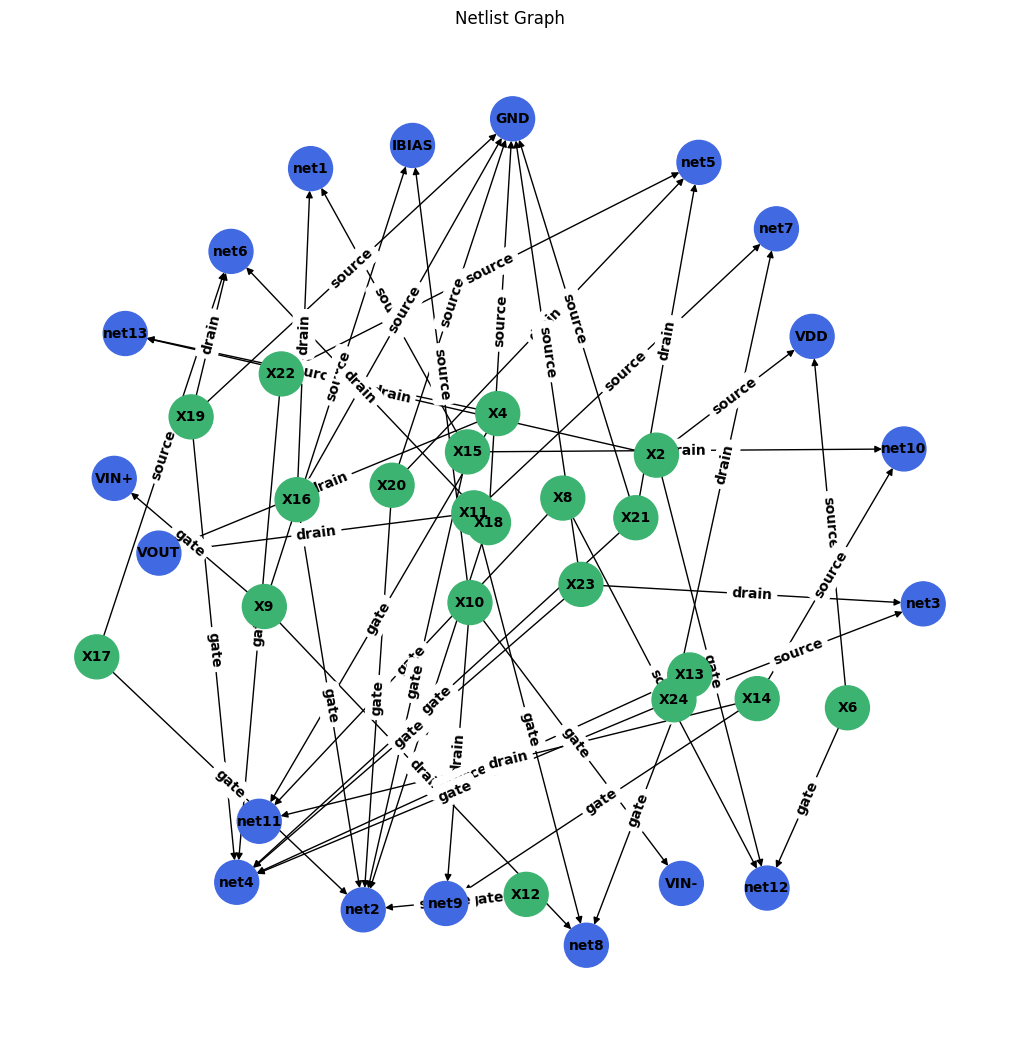

2024-12-04 09:50:01.909 | INFO     | gdsfactory.pdk:activate:337 - 'sky130' PDK is now active
<ipython-input-22-3e7f5cac144a>:11: UserWarning: Unnamed cells, 20 in 'final_layout'
  Componente.write_gds('Component.gds')
2024-12-04 09:53:14.293 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'Component.gds'


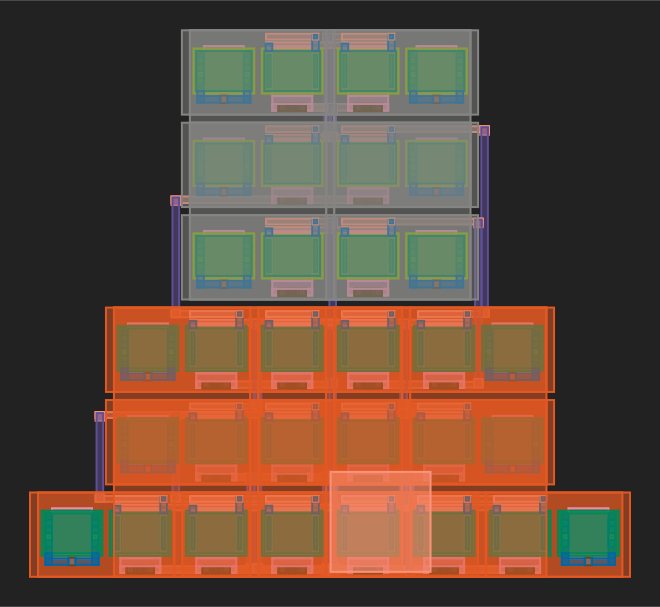

In [ ]:
#_________USER INPUT_________________________
circuit_name = "VMA"  # Define the name of the circuit

#_________PROGRAM____________________________
sch_file_name = '/content/'+str(circuit_name)+'.sch'  # Define the schematic file path
netlist_file_name = '/content/'+str(circuit_name)+'.spice'  # Define the netlist file path
df_SpacePosition = parse_transistor_file(sch_file_name, sort_by='Y')  # Parse the transistor file and sort by Y-coordinate
sorted = sort_positions(df_SpacePosition)  # Sort the transistor positions
netlist = extract_transistor_data_from_file(netlist_file_name)  # Extract transistor data from the netlist file
G = create_grapho(netlist, k_value=1, fig_size=(10, 10))  # Create a graph of the netlist
Componente = create_layout(sky130_mapped_pdk, width=2, length=2, sorted_positions=sorted, info_transistors=df_SpacePosition, connections=0)  # Create the layout with specified parameters
Componente.write_gds('Component.gds')  # Write the layout to a GDS file
display_gds('Component.gds', scale=2)  # Display the GDS file


In [ ]:
#from google.colab import files
#files.download('Component.gds')

# DRC Errors & proposal smart_route

Analyzing the results, I observed that the smart route technique does not work properly as it seems to overlook the previously added vias and metals. Consequently, shortcuts appear, and DRC errors occur, as shown in the following images.

The proposed project remains valuable as it would significantly reduce the designer's workload. The designer would only need to verify that the routing is properly done, considering these issues as a baseline.

To address this problem, I have attempted to create an alternative smart route method, which will be explained in the following section.

Upon examining the existing smart_route code, it is evident that it does not check the actual paths that have already been created. While it appears to use the assert_port_manhattan() function to check the current path being created, it does not do so for the previous ones. Therefore, I developed a function that not only optimizes the paths but also ensures no conflicts with the existing versions.

## Initial DRC check with smart_route

It gives errors due to the following conflicts (LVS has not been run yet, but can be observed how clearly shortcuts exist)

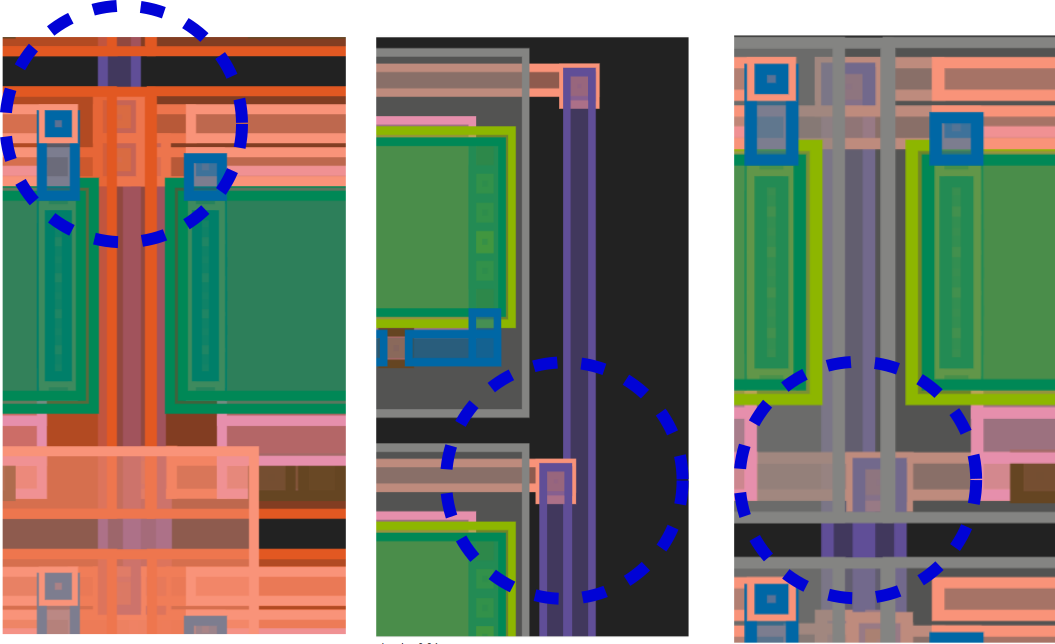

In [ ]:
import re

# Perform the DRC check using KLayout
!klayout Component.gds -zz -r glayout/flow/pdk/sky130_mapped/sky130.lydrc

# Initialize a list to hold the results
results = []

# Read the DRC results file
with open('sky130_drc.txt', 'r') as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        if re.search("<value>", line):
            # Find the corresponding category line
            for j in range(i, 0, -1):
                if re.search("<category>", lines[j]):
                    results.append(lines[j].strip())
                    break
            # Add the value line to results
            results.append(line.strip())

# Print the results
for result in results:
    print(result)


"input" in: sky130.lydrc:71
    Polygons (raw): 32 (flat)  32 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:72
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:73
    Polygons (raw): 18 (flat)  18 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:74
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:75
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:76
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:77
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:78
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:79
    Polygons (raw): 0 (flat)  0 (hierarchical)
 

## Proposed methodology

As with the previous layout design, I have tested multiple versions, each contributing to the understanding of the final code's evolution by adding more features. The following points explain the improvements in each version. It is important to note that to ensure that it worked properly, the tests were conducted on a grid rather than a layout, which helped identify the issues.

*   v0 - In this initial test version, we find the most optimal path using the A* search algorithm, following the provided design order. The black boxes represent cells that cannot be routed.

*   v1 - The algorithm now chooses between multiple materials, allowing for a more optimized path.

*   v2 - The mark_adjacent_cells function is introduced to avoid DRC errors between two paths. The grid size represents the minimum distance between two metals, for instance.

*   v3 - Visualization is improved, and more complex paths are added, necessitating checks to ensure the mark_adjacent_cells function works correctly.

*   v4 - Recognizing that vertical and horizontal paths should use different materials to aid the routing process, the separate_path_by_material function is added, and other functions are updated. Visualization is enhanced to show results clearly, with horizontal paths marked by 'o' and vertical paths by '^'. Start and end points are marked with diamonds.

*   v5 - A restriction is set that the initial and final points must always be metal1 to connect with the transistor. If this is not possible, a via must be added.

*   v6 - Vias are now represented as black squares. This is not just for representation but to ensure the algorithm correctly identifies them, allowing for the proper via selection when applying the PDK.

*   v7 - The backtrack_search function is added to ensure the algorithm explores all possible paths and materials. This addresses the issue where some paths couldn't be completed because the algorithm had already routed a previous path. By checking ""all"" options, it ensures that both paths can be completed if routed differently.


Overall I would say that the most important feature is the fact that if a path cannot be done the algorithms indicates it to the layouter.

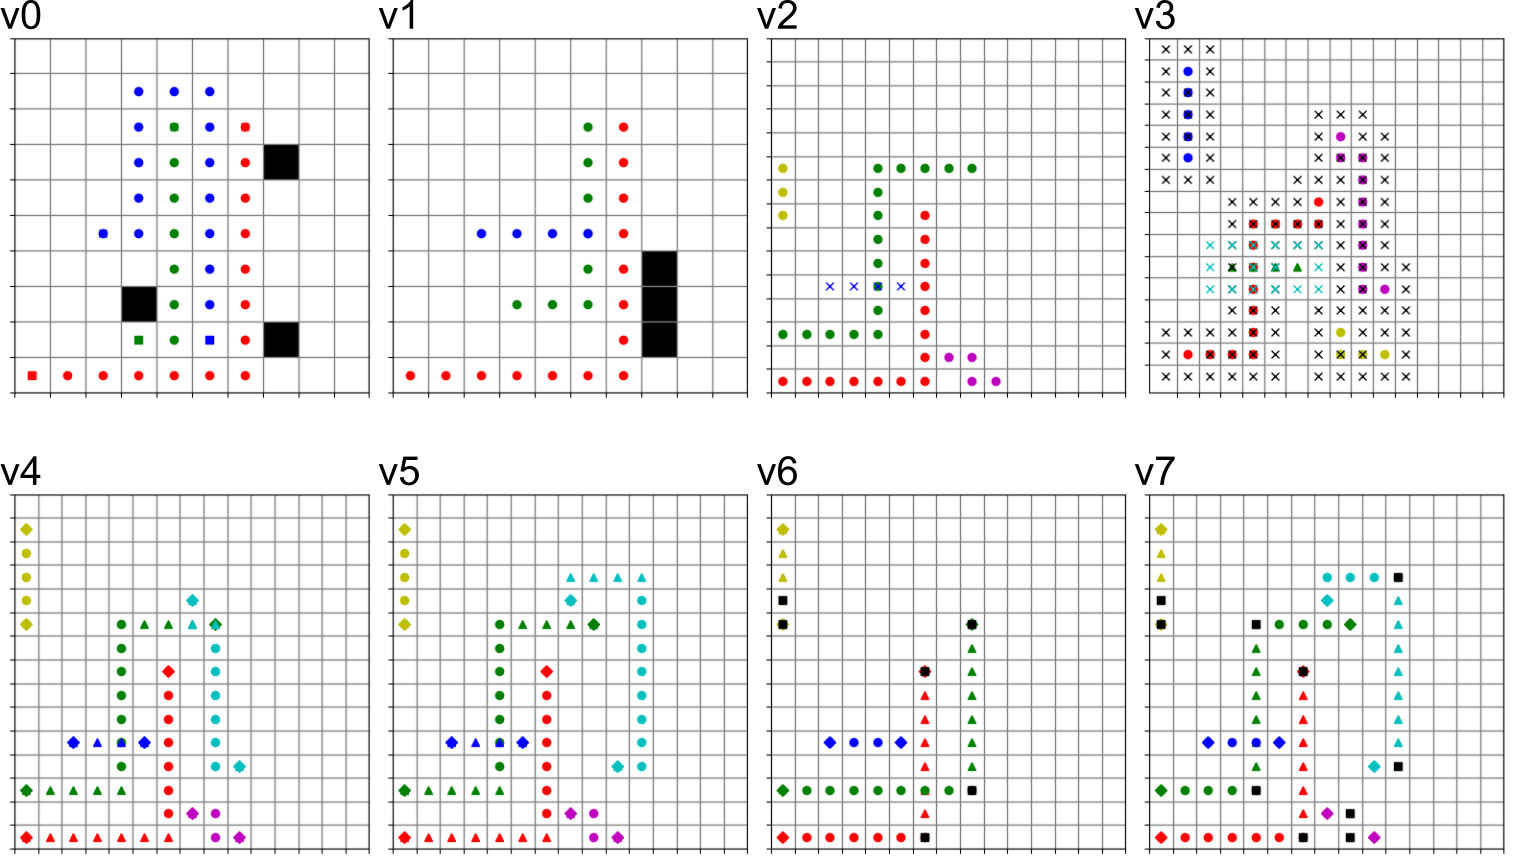

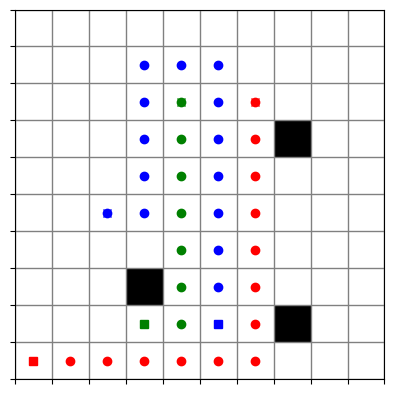

In [ ]:
#@title v.0
import heapq
import numpy as np
import matplotlib.pyplot as plt

# Función heurística para estimar la distancia entre dos puntos (Manhattan distance)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)

            if 0 <= neighbor[0] < grid.shape[0]:
                if 0 <= neighbor[1] < grid.shape[1]:
                    if grid[neighbor[0]][neighbor[1]] == 1 or (neighbor in occupied and neighbor != goal):
                        continue
                else:
                    continue
            else:
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Función para dibujar la cuadrícula y los caminos
def draw_grid(grid, paths, start_goal_pairs):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=plt.cm.binary)

    colors = ['r', 'g', 'b', 'y', 'm', 'c']  # Lista de colores

    # Dibujar los caminos
    for idx, path in enumerate(paths):
        color = colors[idx % len(colors)] + 'o'  # Seleccionar color
        for (i, j) in path:
            ax.plot(j, i, color)

    # Dibujar los puntos iniciales y finales
    for idx, (start, goal) in enumerate(start_goal_pairs):
        start_color = colors[idx % len(colors)] + 's'  # Cuadrado para el punto inicial
        goal_color = colors[idx % len(colors)] + 'x'  # Cruz para el punto final
        ax.plot(start[1], start[0], start_color)
        ax.plot(goal[1], goal[0], goal_color)

    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='gray', linestyle='-', linewidth=1)
    plt.gca().invert_yaxis()
    plt.show()

# Ejemplo de uso
grid = np.zeros((10, 10))
grid[1][7] = 1
grid[2][3] = 1
grid[6][7] = 1

start_goal_pairs = [((0, 0), (7, 6)), ((1, 3), (7, 4)), ((1, 5), (4, 2))]
paths = []
occupied = set()

for start, goal in start_goal_pairs:
    path = a_star_search(grid, start, goal, occupied)
    if path:
        path = path[::-1]  # Invertir el camino para que vaya de inicio a fin
        paths.append(path)
        occupied.update(path)  # Añadir el camino a las celdas ocupadas
    else:
        print(f"No se encontró un camino desde {start} hasta {goal}.")

draw_grid(grid, paths, start_goal_pairs)


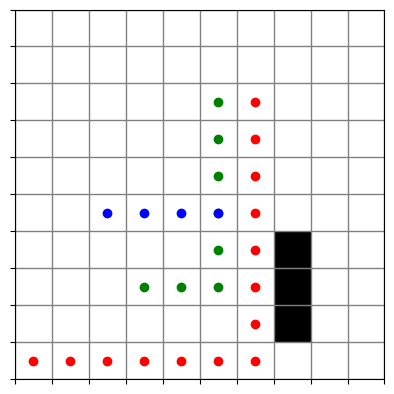

Camino  Puntos   Material
0   Camino_1  (0, 1)  material1
1   Camino_1  (0, 2)  material1
2   Camino_1  (0, 3)  material1
3   Camino_1  (0, 4)  material1
4   Camino_1  (0, 5)  material1
5   Camino_1  (0, 6)  material1
6   Camino_1  (1, 6)  material1
7   Camino_1  (2, 6)  material1
8   Camino_1  (3, 6)  material1
9   Camino_1  (4, 6)  material1
10  Camino_1  (5, 6)  material1
11  Camino_1  (6, 6)  material1
12  Camino_1  (7, 6)  material1
13  Camino_1  (0, 0)  material1
14  Camino_2  (2, 4)  material1
15  Camino_2  (2, 5)  material1
16  Camino_2  (3, 5)  material1
17  Camino_2  (4, 5)  material1
18  Camino_2  (5, 5)  material1
19  Camino_2  (6, 5)  material1
20  Camino_2  (7, 5)  material1
21  Camino_2  (2, 3)  material1
22  Camino_3  (4, 4)  material1
23  Camino_3  (4, 3)  material1
24  Camino_3  (4, 2)  material1
25  Camino_3  (4, 5)  material1

In [ ]:
#@title v.1
#A diferencia del codigo anterior en este añadimos la posibilidad de cambiar de material

import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función heurística para estimar la distancia entre dos puntos (Manhattan distance)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied, material):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = [start]
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)

            if 0 <= neighbor[0] < grid.shape[0]:
                if 0 <= neighbor[1] < grid.shape[1]:
                    if grid[neighbor[0]][neighbor[1]] == 1 or (neighbor in occupied[material] and neighbor != goal):
                        continue
                else:
                    continue
            else:
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Función para dibujar la cuadrícula y los caminos
def draw_grid(grid, paths, start_goal_pairs, materials):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=plt.cm.binary)

    colors = ['r', 'g', 'b', 'y', 'm', 'c']  # Lista de colores

    # Dibujar los caminos
    for idx, path in enumerate(paths):
        material = materials[idx]
        color = colors[idx % len(colors)] + ('x' if material == 'material2' else 'o')  # Seleccionar color y forma
        for (i, j) in path:
            ax.plot(j, i, color)

    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='gray', linestyle='-', linewidth=1)
    plt.gca().invert_yaxis()
    plt.show()

# Ejemplo de uso
grid = np.zeros((10, 10))
grid[1][7] = 1
grid[2][7] = 1
grid[3][7] = 1

start_goal_pairs = [((0, 0), (7, 6)), ((2, 3), (7, 5)), ((4, 5), (4, 2))]
paths = []
materials = []
occupied = {material: set() for material in ['material1', 'material2', 'material3']}  # Lista de materiales
path_names = []

for idx, (start, goal) in enumerate(start_goal_pairs):
    path_name = f"Camino_{idx+1}"
    best_path = None
    best_material = None
    for material in occupied.keys():
        path = a_star_search(grid, start, goal, occupied, material)
        if path:
            path = path[::-1]  # Invertir el camino para que vaya de inicio a fin
            if best_path is None or len(path) < len(best_path):
                best_path = path
                best_material = material
    if best_path:
        paths.append(best_path)
        materials.append(best_material)
        occupied[best_material].update(best_path)  # Añadir el camino a las celdas ocupadas del material correspondiente
        path_names.append(path_name)
    else:
        print(f"No se encontró un camino desde {start} hasta {goal}.")

# Crear el DataFrame
data = []
for path_name, path, material in zip(path_names, paths, materials):
    for point in path:
        data.append([path_name, point, material])

df = pd.DataFrame(data, columns=['Camino', 'Puntos', 'Material'])

draw_grid(grid, paths, start_goal_pairs, materials)
df


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (0, 0)]
[(2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (2, 0)]
[(4, 4), (4, 3), (4, 2), (4, 5)]
[(8, 0), (9, 0), (7, 0)]
[(1, 8), (0, 8), (0, 9), (1, 7)]


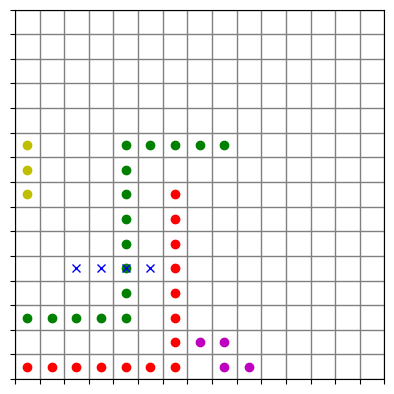

In [ ]:
#@title v.2

#En este codigo se

import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función heurística para estimar la distancia entre dos puntos (Manhattan distance)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función para marcar las celdas adyacentes como ocupadas
def mark_adjacent_cells(occupied, path, start, goal):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    for cell in path:
        for i, j in neighbors:
            adjacent = (cell[0] + i, cell[1] + j)
            if adjacent != start and adjacent != goal:
                occupied.add(adjacent)

def mark_adjacent_cells_init(occupied, cells):
  neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
  for cell in cells:
      print(cell)
      for i, j in neighbors:
          adjacent = (cell[0] + i, cell[1] + j)
          if adjacent != start and adjacent != goal:
              occupied.add(adjacent)
              print("next",adjacent)


# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied, material):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = [start]
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)

            if 0 <= neighbor[0] < grid.shape[0]:
                if 0 <= neighbor[1] < grid.shape[1]:
                    if grid[neighbor[0]][neighbor[1]] == 1 or (neighbor in occupied[material] and neighbor != goal):
                        continue
                else:
                    continue
            else:
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Función para dibujar la cuadrícula y los caminos
def draw_grid(grid, paths, start_goal_pairs, materials):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=plt.cm.binary)

    colors = ['r', 'g', 'b', 'y', 'm', 'c']  # Lista de colores

    # Dibujar los caminos
    for idx, path in enumerate(paths):
        material = materials[idx]
        color = colors[idx % len(colors)] + ('x' if material == 'material2' else 'o')  # Seleccionar color y forma
        for (i, j) in path:
            ax.plot(j, i, color)

    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='gray', linestyle='-', linewidth=1)
    plt.gca().invert_yaxis()
    plt.show()

# Ejemplo de uso
grid = np.zeros((15, 15))

start_goal_pairs = [((0, 0), (7, 6)), ((2,0), (9, 8)), ((4, 5), (4, 2)), ((7, 0), (9, 0)), ((1, 7), (0, 9))]  #(y,x),(y,x)
#start_goal_pairs = [((0, 0), (7, 6))]  #(y,x),(y,x)

paths = []
materials = []
occupied = {material: set() for material in ['material1', 'material2']}  # Lista de materiales
path_names = []

#print(occupied)
#for idx, (start, goal) in enumerate(start_goal_pairs):
#  mark_adjacent_cells_init(occupied['material1'],start_goal_pairs[idx])

#for idx, (start, goal) in enumerate(start_goal_pairs):
#  mark_adjacent_cells_init(occupied['material2'],start_goal_pairs[idx])
#print(occupied)

for idx, (start, goal) in enumerate(start_goal_pairs):
    path_name = f"Camino_{idx+1}"
    best_path = None
    best_material = None
    for material in occupied.keys():
        path = a_star_search(grid, start, goal, occupied, material)
        if path:
            path = path[::-1]  # Invertir el camino para que vaya de inicio a fin
            if best_path is None or len(path) < len(best_path):
                best_path = path
                best_material = material
    if best_path:
        paths.append(best_path)
        materials.append(best_material)
        print(best_path)
        mark_adjacent_cells(occupied[best_material], best_path, start, goal)  # Marcar celdas adyacentes como ocupadas
        path_names.append(path_name)
    else:
        print(f"No se encontró un camino desde {start} hasta {goal}.")

# Crear el DataFrame
data = []
for path_name, path, material in zip(path_names, paths, materials):
    for point in path:
        data.append([path_name, point, material])

df = pd.DataFrame(data, columns=['Camino', 'Coordenadas', 'Material'])

draw_grid(grid, paths, start_goal_pairs, materials)
#df


No se encontró un camino desde (2, 0) hasta (9, 8).


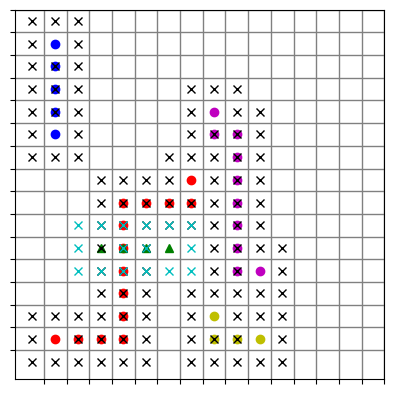

In [ ]:
#@title v.3
import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función heurística para estimar la distancia entre dos puntos (distancia Manhattan)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función para marcar las celdas adyacentes como ocupadas
def mark_adjacent_cells(occupied, path, start, goal, current_material):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    for cell in path:
        for i, j in neighbors:
            adjacent = (cell[0] + i, cell[1] + j)
            if adjacent != start and adjacent != goal:
                occupied[current_material].add(adjacent)

# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied, material, origins):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = [start]
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)

            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue

                if neighbor != goal and neighbor != start:
                    if current != start and neighbor in occupied[material]:
                        continue
                    if current == start and neighbor in occupied[material]:
                        continue

                if any(abs(neighbor[0] - origin[0]) <= 1 and abs(neighbor[1] - origin[1]) <= 1 for origin in origins if origin != start and origin != goal):
                    continue
            else:
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

def draw_grid(grid, paths, start_goal_pairs, materials, occupied):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=plt.cm.binary)

    colors = ['r', 'g', 'b', 'y', 'm', 'c']  # Lista de colores

    # Dibujar los caminos
    for idx, path in enumerate(paths):
        material = materials[idx]
        if material == 'material1':
            marker = 'o'  # Punto para material1
        else:
            marker = '^'  # Triángulo para material2

        color = colors[idx % len(colors)]
        for (i, j) in path:
            ax.plot(j, i, marker + color)

    # Dibujar celdas ocupadas
    for material, cells in occupied.items():
        if material == 'material1':
            color = 'k'  # Negro para celdas adyacentes de material1
        else:
            color = 'c'  # Cian para celdas adyacentes de material2

        for (i, j) in cells:
            ax.plot(j, i, 'x' + color)  # Marcar celdas ocupadas con una 'x'

    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='gray', linestyle='-', linewidth=1)
    plt.gca().invert_yaxis()
    plt.show()

#_______________________________________________________________________________________
#______________________________EJEMPLO__________________________________________________
#_______________________________________________________________________________________

grid = np.zeros((15, 15))  #Dibujamos la cuadricula que queremos

start_goal_pairs = [((0, 0), (7, 6)), ((2, 0), (9, 8)), ((4, 5), (4, 2)), ((9, 0), (13, 0)), ((1, 7), (0, 9)), ((10, 7), (3, 9))]

#Variables iniciales
paths = []
materials = []
occupied = {material: set() for material in ['material1', 'material2']}  # Diccioanrio de materiales
path_names = []
origins = [start for start, goal in start_goal_pairs]

#Loop
for idx, (start, goal) in enumerate(start_goal_pairs):
    path_name = f"Camino_{idx+1}"
    best_path = None
    best_material = None
    for material in occupied.keys():
        path = a_star_search(grid, start, goal, occupied, material, origins)
        if path:
            path = path[::-1]  # Invertir el camino para que vaya de inicio a fin
            if best_path is None or len(path) < len(best_path):
                best_path = path
                best_material = material
    if best_path:
        paths.append(best_path)
        materials.append(best_material)
        mark_adjacent_cells(occupied, best_path, start, goal,best_material)  # Marcar celdas adyacentes como ocupadas
        path_names.append(path_name)
    else:
        print(f"No se encontró un camino desde {start} hasta {goal}.")

# Generamos un DataFrame
data = []
for path_name, path, material in zip(path_names, paths, materials):
    for point in path:
        data.append([path_name, point, material])

df = pd.DataFrame(data, columns=['Camino', 'Coordenadas', 'Material'])

draw_grid(grid, paths, start_goal_pairs, materials,occupied)
#_______________________________________________________________________________________
#_______________________________________________________________________________________
#_______________________________________________________________________________________


(0, 0) (7, 6)
{'material1': set(), 'material2': set()}
(2, 0) (9, 8)
{'material1': {(3, 7), (4, 6), (5, 7), (0, 5), (8, 6), (1, 6), (2, 5), (7, 7), (6, 5), (4, 5), (5, 6), (3, 6), (8, 5), (0, 7), (2, 7), (1, 5), (6, 7), (4, 7), (3, 5), (5, 5), (8, 7), (0, 6), (1, 7), (2, 6), (6, 6), (7, 5)}, 'material2': {(0, 2), (0, 5), (1, 0), (1, 6), (1, 3), (-1, 4), (-1, 1), (-1, 7), (0, 1), (0, 7), (1, 2), (0, 4), (1, 5), (-1, 0), (-1, 3), (-1, 6), (1, 1), (0, 3), (1, 4), (0, 6), (1, 7), (-1, 2), (-1, 5)}}
(4, 5) (4, 2)
{'material1': {(3, 4), (4, 3), (3, 7), (5, 4), (4, 6), (5, 7), (9, 5), (8, 3), (0, 5), (8, 6), (10, 3), (1, 6), (2, 5), (7, 4), (7, 7), (6, 5), (4, 5), (3, 3), (5, 6), (3, 6), (5, 3), (8, 5), (9, 4), (0, 7), (2, 4), (10, 5), (2, 7), (1, 5), (6, 4), (7, 3), (6, 7), (4, 7), (3, 5), (4, 4), (5, 5), (8, 4), (9, 3), (8, 7), (10, 4), (0, 6), (2, 3), (1, 7), (2, 6), (6, 6), (7, 5), (6, 3)}, 'material2': {(3, 4), (3, 1), (9, 5), (0, 2), (8, 9), (10, 6), (0, 5), (2, 2), (1, 0), (1, 6), (8, 

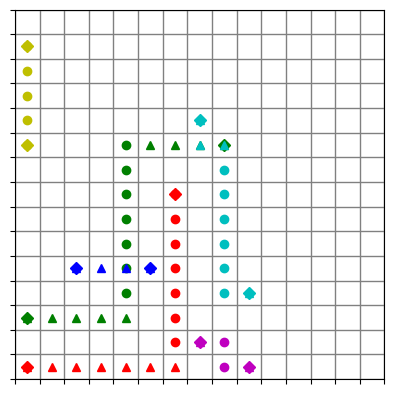

In [ ]:
#@title v.4

import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función heurística para estimar la distancia entre dos puntos (distancia Manhattan)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función para marcar las celdas adyacentes como ocupadas
def mark_adjacent_cells(occupied, path, start, goal):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    segments = separate_path_by_material(path)

    for segment, material in segments:
        if material is not None:  # Asegurarse de que el material no sea None
            for cell in segment:
                for i, j in neighbors:
                    adjacent = (cell[0] + i, cell[1] + j)
                    if adjacent != start and adjacent != goal:
                        occupied[material].add(adjacent)


# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied, material, origins):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = [start]
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data[::-1]

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1

            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue

                # Comprobar si la celda está ocupada por el mismo material
                if neighbor in occupied[material]:
                    continue

                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, float('inf')):
                    continue

                if tentative_g_score < gscore.get(neighbor, float('inf')) or neighbor not in [i[1] for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Función para identificar si el movimiento es horizontal o vertical
def get_material_for_segment(segment_start, segment_end):
    if segment_start[1] == segment_end[1]:
        return 'material1' # Horizontal
    elif segment_start[0] == segment_end[0]:
        return 'material2' # Vertical
    return None

# Función para separar el camino en segmentos horizontales y verticales
def separate_path_by_material(path):
    if len(path) < 2:
        return []

    segments = []
    current_segment = [path[0]]
    current_material = get_material_for_segment(path[0], path[1])

    for i in range(1, len(path)):
        segment_material = get_material_for_segment(path[i-1], path[i])
        if segment_material == current_material:
            current_segment.append(path[i])
        else:
            segments.append((current_segment, current_material))
            current_segment = [path[i]]
            current_material = segment_material

    segments.append((current_segment, current_material))
    return segments

# Función para dibujar la cuadrícula
# Función para dibujar la cuadrícula
def draw_grid(grid, paths, start_goal_pairs, occupied):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=plt.cm.binary)
    colors = ['r', 'g', 'b', 'y', 'm', 'c'] # Lista de colores

    # Dibujar los caminos
    for idx, path in enumerate(paths):
        segments = separate_path_by_material(path)
        color = colors[idx % len(colors)]
        for segment, material in segments:
            if material == 'material1':
                marker = 'o' # Punto para material1 (horizontal)
            else:
                marker = '^' # Triángulo para material2 (vertical)
            for (i, j) in segment:
                ax.plot(j, i, marker + color)

        # Marcar el inicio y el final del camino con diamantes
        start, goal = start_goal_pairs[idx]
        ax.plot(start[1], start[0], 'D' + color) # Diamante en el punto de inicio
        ax.plot(goal[1], goal[0], 'D' + color)   # Diamante en el punto de final

    '''
    # Dibujar celdas ocupadas
    for material, cells in occupied.items():
        if material == 'material1':
            color = 'k' # Negro para celdas adyacentes de material1
        else:
            color = 'c' # Cian para celdas adyacentes de material2
        for (i, j) in cells:
            ax.plot(j, i, 'x' + color) # Marcar celdas ocupadas con una 'x'
    '''
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='gray', linestyle='-', linewidth=1)
    plt.gca().invert_yaxis()
    plt.show()


# Ejemplo de uso
grid = np.zeros((15, 15)) # Dibujamos la cuadricula que queremos
start_goal_pairs = [((0, 0), (7, 6)), ((2, 0), (9, 8)), ((4, 5), (4, 2)), ((9, 0), (13, 0)), ((1, 7), (0, 9)), ((10, 7), (3, 9))] # Variables iniciales
paths = []
occupied = {material: set() for material in ['material1', 'material2']} # Diccionario de materiales
path_names = []
origins = [start for start, goal in start_goal_pairs]

# Loop para encontrar los caminos
for idx, (start, goal) in enumerate(start_goal_pairs):
    print(start, goal)
    print(occupied)
    path_name = f"Camino_{idx+1}"
    best_path = None
    for material in occupied.keys():
        path = a_star_search(grid, start, goal, occupied, material, origins)
        if path:
            if best_path is None or len(path) < len(best_path):
                best_path = path
    if best_path:
        paths.append(best_path)
        mark_adjacent_cells(occupied, best_path, start, goal) # Marcar celdas adyacentes como ocupadas
        path_names.append(path_name)
    else:
        print(f"No se encontró un camino desde {start} hasta {goal}.")

# Generamos un DataFrame
data = []
for path_name, path in zip(path_names, paths):
    segments = separate_path_by_material(path)
    for segment, material in segments:
        for point in segment:
            data.append([path_name, point, material])
df = pd.DataFrame(data, columns=['Camino', 'Coordenadas', 'Material'])

# Dibujamos la cuadrícula con los caminos
draw_grid(grid, paths, start_goal_pairs, occupied)



(0, 0) (7, 6)
{'material1': set(), 'material2': set()}
(2, 0) (9, 8)
{'material1': {(3, 7), (4, 6), (5, 7), (8, 6), (0, 5), (1, 0), (1, 6), (2, 5), (-1, -1), (7, 7), (6, 5), (-1, 1), (4, 5), (5, 6), (3, 6), (0, -1), (8, 5), (0, 1), (0, 7), (2, 7), (1, 5), (-1, 0), (6, 7), (7, 6), (4, 7), (3, 5), (5, 5), (0, 0), (8, 7), (1, 1), (1, -1), (0, 6), (1, 7), (2, 6), (6, 6), (7, 5)}, 'material2': {(0, 2), (0, 5), (1, 0), (1, 6), (1, 3), (-1, 4), (-1, 1), (-1, 7), (0, 1), (0, 7), (1, 2), (0, 4), (1, 5), (-1, 0), (-1, 3), (-1, 6), (1, 1), (0, 3), (1, 4), (0, 6), (1, 7), (-1, 2), (-1, 5)}}
(4, 5) (4, 2)
{'material1': {(3, -1), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 7), (9, 5), (8, 3), (8, 9), (9, 8), (8, 6), (0, 5), (1, 0), (1, 6), (10, 9), (2, 5), (10, 3), (7, 4), (-1, -1), (7, 7), (6, 5), (-1, 1), (3, 0), (4, 5), (3, 3), (5, 6), (3, 6), (5, 3), (0, -1), (8, 5), (9, 7), (9, 4), (0, 1), (0, 7), (2, -1), (8, 8), (2, 4), (2, 1), (2, 7), (1, 5), (10, 8), (10, 5), (6, 4), (7, 3), (-1, 0)

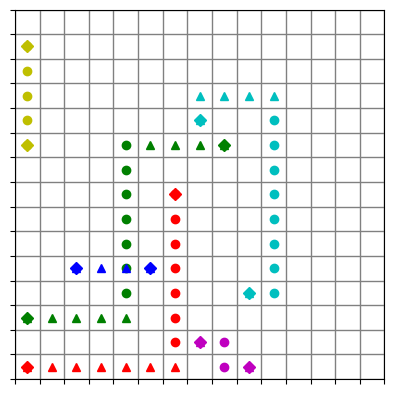

In [ ]:
#@title v.5
#EL PUNTO DE INICIO Y FINAL SIEMPRE DEBÍA SER MATERIAL1
import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función heurística para estimar la distancia entre dos puntos (distancia Manhattan)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función para marcar las celdas adyacentes como ocupadas
def mark_adjacent_cells(occupied, path, start, goal):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

    # Marcar el inicio y el final con material1
    for cell in [start, goal]:
        for i, j in neighbors:
            adjacent = (cell[0] + i, cell[1] + j)
            if adjacent != start and adjacent != goal:
                occupied['material1'].add(adjacent)

    segments = separate_path_by_material(path)
    for segment, material in segments:
        if material is not None:
            for cell in segment:
                for i, j in neighbors:
                    adjacent = (cell[0] + i, cell[1] + j)
                    if adjacent != start and adjacent != goal:
                        occupied[material].add(adjacent)



# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied, material, origins):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = [start]
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data[::-1]

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1

            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue

                # Comprobar si la celda está ocupada por el mismo material
                if neighbor in occupied[material]:
                    continue

                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, float('inf')):
                    continue

                if tentative_g_score < gscore.get(neighbor, float('inf')) or neighbor not in [i[1] for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Función para identificar si el movimiento es horizontal o vertical
def get_material_for_segment(segment_start, segment_end):
    if segment_start[1] == segment_end[1]:
        return 'material1' # Horizontal
    elif segment_start[0] == segment_end[0]:
        return 'material2' # Vertical
    return None

# Función para separar el camino en segmentos horizontales y verticales
def separate_path_by_material(path):
    if len(path) < 2:
        return []

    segments = []
    current_segment = [path[0]]
    current_material = get_material_for_segment(path[0], path[1])

    for i in range(1, len(path)):
        segment_material = get_material_for_segment(path[i-1], path[i])
        if segment_material == current_material:
            current_segment.append(path[i])
        else:
            segments.append((current_segment, current_material))
            current_segment = [path[i]]
            current_material = segment_material

    segments.append((current_segment, current_material))
    return segments

# Función para dibujar la cuadrícula
# Función para dibujar la cuadrícula
def draw_grid(grid, paths, start_goal_pairs, occupied):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=plt.cm.binary)
    colors = ['r', 'g', 'b', 'y', 'm', 'c'] # Lista de colores

    # Dibujar los caminos
    for idx, path in enumerate(paths):
        segments = separate_path_by_material(path)
        color = colors[idx % len(colors)]
        for segment, material in segments:
            if material == 'material1':
                marker = 'o' # Punto para material1 (horizontal)
            else:
                marker = '^' # Triángulo para material2 (vertical)
            for (i, j) in segment:
                ax.plot(j, i, marker + color)

        # Marcar el inicio y el final del camino con diamantes
        start, goal = start_goal_pairs[idx]
        ax.plot(start[1], start[0], 'D' + color) # Diamante en el punto de inicio
        ax.plot(goal[1], goal[0], 'D' + color)   # Diamante en el punto de final

    '''
    # Dibujar celdas ocupadas
    for material, cells in occupied.items():
        if material == 'material1':
            color = 'k' # Negro para celdas adyacentes de material1
        else:
            color = 'c' # Cian para celdas adyacentes de material2
        for (i, j) in cells:
            ax.plot(j, i, 'x' + color) # Marcar celdas ocupadas con una 'x'
    '''
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='gray', linestyle='-', linewidth=1)
    plt.gca().invert_yaxis()
    plt.show()


# Ejemplo de uso
grid = np.zeros((15, 15)) # Dibujamos la cuadricula que queremos
start_goal_pairs = [((0, 0), (7, 6)), ((2, 0), (9, 8)), ((4, 5), (4, 2)), ((9, 0), (13, 0)), ((1, 7), (0, 9)), ((10, 7), (3, 9))] # Variables iniciales
paths = []
occupied = {material: set() for material in ['material1', 'material2']} # Diccionario de materiales
path_names = []
origins = [start for start, goal in start_goal_pairs]

# Loop para encontrar los caminos
for idx, (start, goal) in enumerate(start_goal_pairs):
    print(start, goal)
    print(occupied)
    path_name = f"Camino_{idx+1}"
    best_path = None
    for material in occupied.keys():
        path = a_star_search(grid, start, goal, occupied, material, origins)
        if path:
            if best_path is None or len(path) < len(best_path):
                best_path = path
    if best_path:
        paths.append(best_path)
        # Marcar las celdas adyacentes según el material del segmento
        mark_adjacent_cells(occupied, best_path, start, goal)
        # Marcar inicio y final con material1
        occupied['material1'].add(start)
        occupied['material1'].add(goal)
        path_names.append(path_name)
    else:
        print(f"No se encontró un camino desde {start} hasta {goal}.")


# Generamos un DataFrame
data = []
for path_name, path in zip(path_names, paths):
    segments = separate_path_by_material(path)
    for segment, material in segments:
        for point in segment:
            data.append([path_name, point, material])
df = pd.DataFrame(data, columns=['Camino', 'Coordenadas', 'Material'])

# Dibujamos la cuadrícula con los caminos
draw_grid(grid, paths, start_goal_pairs, occupied)



No se encontró un camino desde (1, 7) hasta (0, 9).
No se encontró un camino desde (10, 7) hasta (3, 9).
Puntos negros: [(0, 6), (7, 6), (2, 8), (9, 8), (10, 0), (9, 0)]


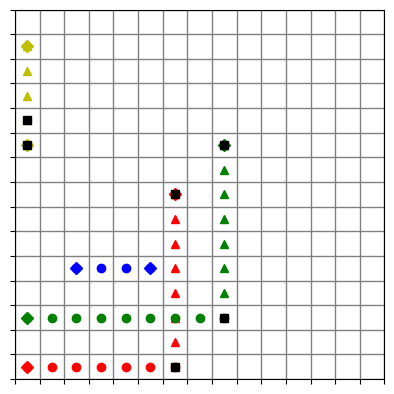

In [ ]:
#@title v.6
#EL PUNTO DE INICIO Y FINAL SIEMPRE DEBÍA SER MATERIAL1
import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función heurística para estimar la distancia entre dos puntos (distancia Manhattan)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función para marcar las celdas adyacentes como ocupadas
def mark_adjacent_cells(occupied, path, start, goal):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

    # Marcar el inicio y el final con material1
    for cell in [start, goal]:
        for i, j in neighbors:
            adjacent = (cell[0] + i, cell[1] + j)
            if adjacent != start and adjacent != goal:
                occupied['material1'].add(adjacent)

    segments, black_points = separate_path_by_material(path)  # Desempaquetar segmentos y puntos negros
    for segment, material in segments:
        if material is not None:
            for cell in segment:
                for i, j in neighbors:
                    adjacent = (cell[0] + i, cell[1] + j)
                    if adjacent != start and adjacent != goal:
                        occupied[material].add(adjacent)

    # Añadir las celdas alrededor de los puntos negros a ambos materiales
    for cell in black_points:
        for i, j in neighbors:
            adjacent = (cell[0] + i, cell[1] + j)
            if adjacent != start and adjacent != goal:
                occupied['material1'].add(adjacent)
                occupied['material2'].add(adjacent)


# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied, material, origins):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = [start]
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data[::-1]

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1

            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue

                # Comprobar si la celda está ocupada por el mismo material
                if neighbor in occupied[material]:
                    continue

                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, float('inf')):
                    continue

                if tentative_g_score < gscore.get(neighbor, float('inf')) or neighbor not in [i[1] for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Función para identificar si el movimiento es horizontal o vertical
# Función para identificar si el movimiento es horizontal o vertical
def get_material_for_segment(segment_start, segment_end):
    if segment_start[1] != segment_end[1]:  # Misma fila, diferente columna
        return 'material1'  # Horizontal
    elif segment_start[0] != segment_end[0]:  # Misma columna, diferente fila
        return 'material2'  # Vertical
    return None


# Función para separar el camino en segmentos horizontales y verticales y marcar puntos de cambio de material
# Función para separar el camino en segmentos horizontales y verticales y marcar puntos de cambio de material
def separate_path_by_material(path):
    if len(path) < 2:
        return [], []

    segments = []
    black_points = []
    current_segment = [path[0]]
    current_material = get_material_for_segment(path[0], path[1])

    for i in range(1, len(path)):
        segment_material = get_material_for_segment(path[i-1], path[i])
        if segment_material == current_material:
            current_segment.append(path[i])
        else:
            segments.append((current_segment, current_material))
            black_points.append(path[i-1])  # Marcar el punto de cambio de material
            current_segment = [path[i]]
            current_material = segment_material

    segments.append((current_segment, current_material))

    # Asegurarse de que los puntos de inicio y fin estén marcados si hay un cambio de material
    if get_material_for_segment(path[0], path[1]) != 'material1':
        black_points.insert(0, path[0])
    if get_material_for_segment(path[-2], path[-1]) != 'material1':
        black_points.append(path[-1])

    return segments, black_points





# Función para dibujar la cuadrícula
# Función para dibujar la cuadrícula
# Función para dibujar la cuadrícula
def draw_grid(grid, paths, start_goal_pairs, occupied):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=plt.cm.binary)
    colors = ['r', 'g', 'b', 'y', 'm', 'c']  # Lista de colores
    black_points = []  # Lista para almacenar puntos negros

    # Dibujar los caminos
    for idx, path in enumerate(paths):
        segments, path_black_points = separate_path_by_material(path)
        black_points.extend(path_black_points)  # Agregar puntos negros del camino actual
        color = colors[idx % len(colors)]
        for segment, material in segments:
            if material == 'material1':
                marker = 'o'  # Punto para material1 (horizontal)
            else:
                marker = '^'  # Triángulo para material2 (vertical)
            for (i, j) in segment:
                ax.plot(j, i, marker + color)

        # Marcar el inicio y el final del camino con diamantes
        start, goal = start_goal_pairs[idx]
        ax.plot(start[1], start[0], 'D' + color)  # Diamante en el punto de inicio
        ax.plot(goal[1], goal[0], 'D' + color)    # Diamante en el punto de final

    # Dibujar puntos negros
    for (i, j) in black_points:
        ax.plot(j, i, 'ks')  # Marcar con un cuadrado negro

    # Imprimir puntos negros
    print("Puntos negros:", black_points)

    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='gray', linestyle='-', linewidth=1)
    plt.gca().invert_yaxis()
    plt.show()





# Ejemplo de uso
grid = np.zeros((15, 15)) # Dibujamos la cuadricula que queremos
start_goal_pairs = [((0, 0), (7, 6)), ((2, 0), (9, 8)), ((4, 5), (4, 2)), ((9, 0), (13, 0)), ((1, 7), (0, 9)), ((10, 7), (3, 9))] # Variables iniciales
paths = []
occupied = {material: set() for material in ['material1', 'material2']} # Diccionario de materiales
path_names = []
origins = [start for start, goal in start_goal_pairs]

# Loop para encontrar los caminos
for idx, (start, goal) in enumerate(start_goal_pairs):
    path_name = f"Camino_{idx+1}"
    best_path = None
    for material in occupied.keys():
        path = a_star_search(grid, start, goal, occupied, material, origins)
        if path:
            if best_path is None or len(path) < len(best_path):
                best_path = path
    if best_path:
        paths.append(best_path)
        # Marcar las celdas adyacentes según el material del segmento
        mark_adjacent_cells(occupied, best_path, start, goal)
        # Marcar inicio y final con material1
        occupied['material1'].add(start)
        occupied['material1'].add(goal)
        path_names.append(path_name)
    else:
        print(f"No se encontró un camino desde {start} hasta {goal}.")


# Generamos un DataFrame
data = []
for path_name, path in zip(path_names, paths):
    segments, _ = separate_path_by_material(path)  # Desempaquetar solo los segmentos
    for segment, material in segments:
        for point in segment:
            data.append([path_name, point, material])
df = pd.DataFrame(data, columns=['Camino', 'Coordenadas', 'Material'])

# Dibujamos la cuadrícula con los caminos
draw_grid(grid, paths, start_goal_pairs, occupied)

Puntos negros: [(0, 6), (7, 6), (2, 4), (9, 4), (10, 0), (9, 0), (1, 8), (0, 8), (11, 10), (3, 10)]


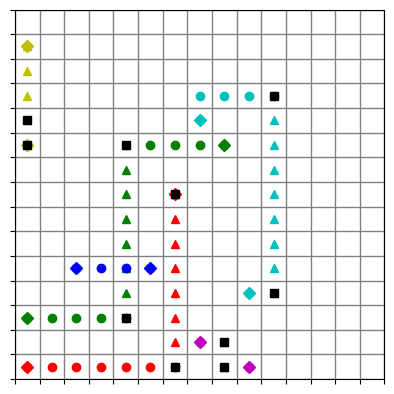

In [ ]:
#@title v.7
import heapq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función heurística para estimar la distancia entre dos puntos (distancia Manhattan)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Función para marcar las celdas adyacentes como ocupadas
def mark_adjacent_cells(occupied, path, start, goal):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

    # Marcar el inicio y el final con material1
    for cell in [start, goal]:
        for i, j in neighbors:
            adjacent = (cell[0] + i, cell[1] + j)
            if adjacent != start and adjacent != goal:
                occupied['material1'].add(adjacent)

    segments, black_points = separate_path_by_material(path)  # Desempaquetar segmentos y puntos negros
    for segment, material in segments:
        if material is not None:
            for cell in segment:
                for i, j in neighbors:
                    adjacent = (cell[0] + i, cell[1] + j)
                    if adjacent != start and adjacent != goal:
                        occupied[material].add(adjacent)

    # Añadir las celdas alrededor de los puntos negros a ambos materiales
    for cell in black_points:
        for i, j in neighbors:
            adjacent = (cell[0] + i, cell[1] + j)
            if adjacent != start and adjacent != goal:
                occupied['material1'].add(adjacent)
                occupied['material2'].add(adjacent)

# Función principal del algoritmo A*
def a_star_search(grid, start, goal, occupied, material):
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = [start]
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data[::-1]

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1

            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue

                # Comprobar si la celda está ocupada por el mismo material
                if neighbor in occupied[material]:
                    continue

                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, float('inf')):
                    continue

                if tentative_g_score < gscore.get(neighbor, float('inf')) or neighbor not in [i[1] for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Función para identificar si el movimiento es horizontal o vertical
def get_material_for_segment(segment_start, segment_end):
    if segment_start[1] != segment_end[1]:  # Misma fila, diferente columna
        return 'material1'  # Horizontal
    elif segment_start[0] != segment_end[0]:  # Misma columna, diferente fila
        return 'material2'  # Vertical
    return None

# Función para separar el camino en segmentos horizontales y verticales y marcar puntos de cambio de material
def separate_path_by_material(path):
    if len(path) < 2:
        return [], []

    segments = []
    black_points = []
    current_segment = [path[0]]
    current_material = get_material_for_segment(path[0], path[1])

    for i in range(1, len(path)):
        segment_material = get_material_for_segment(path[i-1], path[i])
        if segment_material == current_material:
            current_segment.append(path[i])
        else:
            segments.append((current_segment, current_material))
            black_points.append(path[i-1])  # Marcar el punto de cambio de material
            current_segment = [path[i]]
            current_material = segment_material

    segments.append((current_segment, current_material))

    # Asegurarse de que los puntos de inicio y fin estén marcados si hay un cambio de material
    if get_material_for_segment(path[0], path[1]) != 'material1':
        black_points.insert(0, path[0])
    if get_material_for_segment(path[-2], path[-1]) != 'material1':
        black_points.append(path[-1])

    return segments, black_points
# Función de búsqueda con backtracking
def backtrack_search(grid, start_goal_pairs):
    def search_path(start, goal, occupied, material):
        return a_star_search(grid, start, goal, occupied, material)

    def backtrack(paths, occupied, idx):
        if idx == len(start_goal_pairs):
            return True

        start, goal = start_goal_pairs[idx]
        original_occupied = {k: v.copy() for k, v in occupied.items()}  # Copiar el estado original
        best_path = None

        # Intentar encontrar el mejor camino con el material 'material1'
        path = search_path(start, goal, occupied, 'material1')
        if path:
            paths.append(path)
            mark_adjacent_cells(occupied, path, start, goal)
            occupied['material1'].add(start)
            occupied['material1'].add(goal)
            if backtrack(paths, occupied, idx + 1):
                return True
            paths.pop()
            occupied = original_occupied

        # Intentar encontrar el mejor camino con el material 'material2'
        path = search_path(start, goal, occupied, 'material2')
        if path:
            paths.append(path)
            mark_adjacent_cells(occupied, path, start, goal)
            occupied['material2'].add(start)
            occupied['material2'].add(goal)
            if backtrack(paths, occupied, idx + 1):
                return True
            paths.pop()
            occupied = original_occupied

        return False

    paths = []
    occupied = {material: set() for material in ['material1', 'material2']}
    if backtrack(paths, occupied, 0):
        return paths
    else:
        return None  # No se encontró una solución viable
# Ejemplo de uso
grid = np.zeros((15, 15))  # Dibujamos la cuadricula que queremos
start_goal_pairs = [((0, 0), (7, 6)), ((2, 0), (9, 8)), ((4, 5), (4, 2)), ((9, 0), (13, 0)), ((1, 7), (0, 9)), ((10, 7), (3, 9))]  # Variables iniciales

# Llamamos a la función de búsqueda con backtracking
paths = backtrack_search(grid, start_goal_pairs)

# Generamos un DataFrame
data = []
if paths:
    for idx, path in enumerate(paths):
        path_name = f"Camino_{idx+1}"
        segments, _ = separate_path_by_material(path)  # Desempaquetar solo los segmentos
        for segment, material in segments:
            for point in segment:
                data.append([path_name, point, material])
    df = pd.DataFrame(data, columns=['Camino', 'Coordenadas', 'Material'])

    # Dibujamos la cuadrícula con los caminos
    draw_grid(grid, paths, start_goal_pairs, {material: set() for material in ['material1', 'material2']})
else:
    print("No se encontraron caminos viables.")


This algorithm offers valuable enhancements to the existing smart_route. It would be beneficial to merge both, as not all the advantageous features of the current smart_route have been incorporated into this pseudo-version. However, some features in this version add significant value and could be implemented.

Due to time constraints, the algorithm has not been integrated into the layout. My plan is to adapt the values from the ports dictionary (in the layout code) to match what I have represented here as start_goal_pairs.

# Improvements to be done:

Even though the initial purpose of the project was to develop a comprehensive tool, it hasn't been possible due to time constraints (I was in the process of a tapeout). Additionally, issues arose because the smart_route is not as intelligent as it initially seemed. However, I truly believe that the proposals in this project can assist the designer. It may not perform the entire task as I originally expected, but it does help with positioning and placing the wells, which is a positive outcome. Below is a list of all the tasks I intended to complete but couldn't due to time limitations. From my point of view, if these tasks are completed, one could have a truly useful program:

1.   Adding transistor bulk
2.   Creating pin names
3.   Connecting dummy transistors to VDD
4.   DRC check
5.   LVS check
6.   Optimizing placing
7.   Do tests with common centroid
8.   Using a new smart_route method

Developing this project has helped me become more familiar with these open-source tools, which I didn't know before. I am excited to use them in the near future. Thank you for this opportunity.


